In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))

source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

gene     guide1      guide2      alias    subclass class    
1 CD13     CD13-1a     CD13-1b     ANPEP    tss      targeting
2 CD55     CD55-1a     CD55-1b     CD55     tss      targeting
3 CD73     CD73-1a     CD-73-1b    NT5E     tss      targeting
4 FUBP1    FUBP1-1a    FUBP1-1b    FUBP1    tss      targeting
5 C15orf40 C150rf40-1a C15orf40-1b C15orf40 tss      targeting
6 MAFF     MAFF-1a     MAFF-1b     MAFF     tss      targeting

## FeaturePlot singlet & doublet

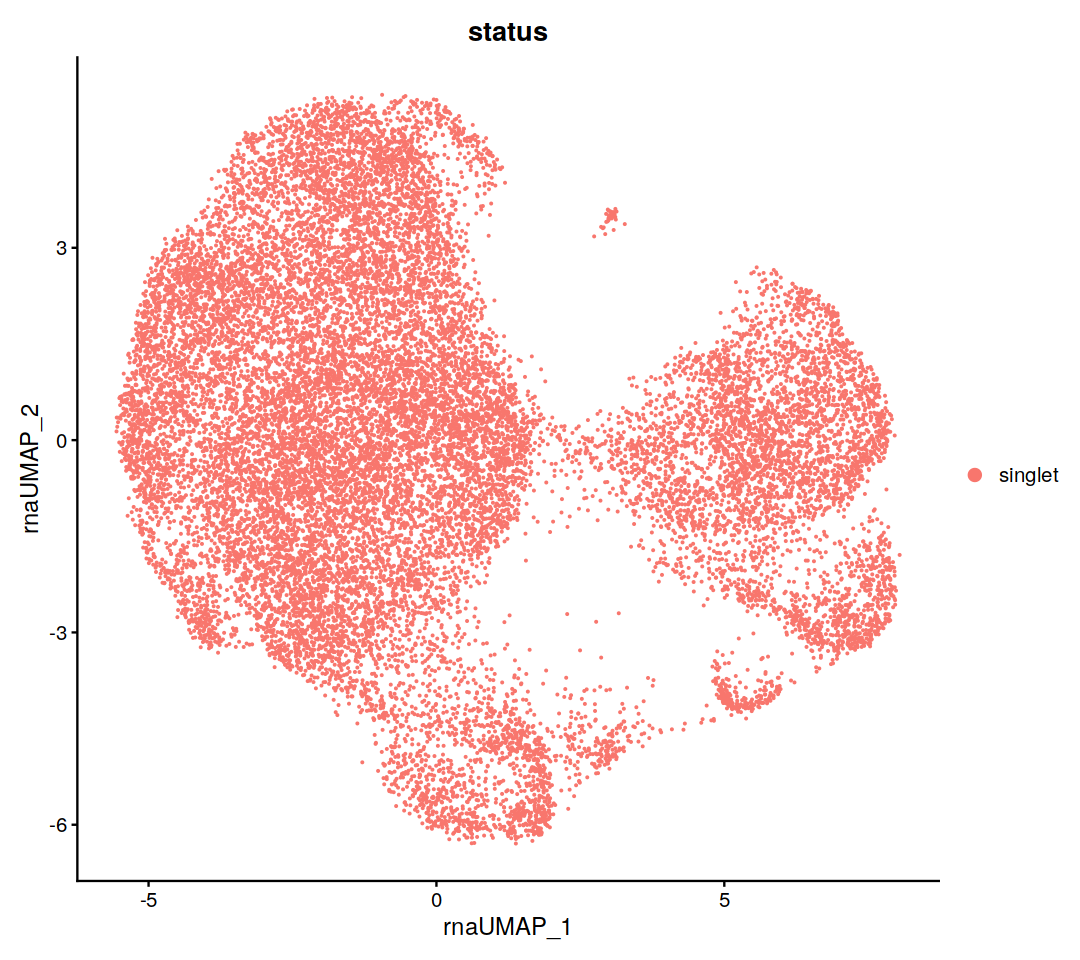

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries) {
        seurat_lib = seurat_libs[[lib]]
        threshold = df_thresholds[i, lib]
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 947

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [14]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

Guide+ = 20151 ; Guide- = 1213 


# Split by donor, then run DE testing 

In [15]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [40]:
targets = unique(filter(df_guide, class=='targeting')$alias)
df_de = NULL
genes_to_skip = c("CD55", "CSTB", "DE11")
genes_to_skip = c()
donors = sort(unique(seurat_rna$donor))
lfc_threshold = 0.25

for(donor_id in donors){
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)
    
    cat(green("Running Donor#", donor_id, "\n"))
    for(target in targets){
        if(target %in% genes_to_skip){
            cat(red("Skipping", target, "\n"))
            next
        }
        guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
        cat(blue(target,":"), paste(guides_4_target, collapse=","),"\n")
        seurat_dummy <- mark_target_pos_neg(seurat_donor, perturbed_cells_by_guide, guides_4_target, print_counts = T)
        
        markers <- FindMarkers(
            object = seurat_dummy,
            slot = "data",
            ident.1 = 'target_positive',
            ident.2 = 'target_negative',
            test.use = "MAST",
            latent.vars = c("library"),
            logfc.threshold = lfc_threshold,
            verbose = FALSE
        )
        # latent.vars = c('library') 
        if(nrow(markers)==0) {
            cat(Red("No DE genes", target,  "\n"))
        }
        markers$de_gene = rownames(markers)
        markers$target  = target
        markers$donor   = donor_id
        rownames(markers) <- NULL
        df_de = rbind(df_de, markers)
    }
}

Running Donor# 0 
ANPEP : CD13-1a,CD13-1b 
Guide+ = 350 ; Guide- = 5297 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CD55 : CD55-1a,CD55-1b 
Guide+ = 346 ; Guide- = 5301 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

NT5E : CD73-1a,CD-73-1b 
Guide+ = 223 ; Guide- = 5424 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 259 ; Guide- = 5388 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

C15orf40 : C150rf40-1a,C15orf40-1b 
Guide+ = 248 ; Guide- = 5399 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

MAFF : MAFF-1a,MAFF-1b 
Guide+ = 251 ; Guide- = 5396 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 1004 ; Guide- = 4643 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 629 ; Guide- = 5018 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
Guide+ = 589 ; Guide- = 5058 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
Guide+ = 628 ; Guide- = 5019 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 721 ; Guide- = 4926 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 665 ; Guide- = 4982 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 691 ; Guide- = 4956 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 689 ; Guide- = 4958 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 383 ; Guide- = 5264 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 719 ; Guide- = 4928 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 747 ; Guide- = 4900 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 710 ; Guide- = 4937 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 886 ; Guide- = 4762 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 725 ; Guide- = 4922 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 826 ; Guide- = 4821 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 451 ; Guide- = 5196 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 569 ; Guide- = 5078 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 706 ; Guide- = 4941 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 609 ; Guide- = 5038 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 507 ; Guide- = 5140 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 666 ; Guide- = 4981 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 712 ; Guide- = 4935 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 553 ; Guide- = 5094 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 642 ; Guide- = 5005 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

Running Donor# 1 
ANPEP : CD13-1a,CD13-1b 
Guide+ = 293 ; Guide- = 4347 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CD55 : CD55-1a,CD55-1b 
Guide+ = 282 ; Guide- = 4358 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

NT5E : CD73-1a,CD-73-1b 
Guide+ = 195 ; Guide- = 4445 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 237 ; Guide- = 4403 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

C15orf40 : C150rf40-1a,C15orf40-1b 
Guide+ = 215 ; Guide- = 4425 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

MAFF : MAFF-1a,MAFF-1b 
Guide+ = 224 ; Guide- = 4416 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 865 ; Guide- = 3775 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 544 ; Guide- = 4096 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
Guide+ = 488 ; Guide- = 4152 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
Guide+ = 522 ; Guide- = 4118 



 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 573 ; Guide- = 4067 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 558 ; Guide- = 4082 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 557 ; Guide- = 4083 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 537 ; Guide- = 4103 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 292 ; Guide- = 4348 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 590 ; Guide- = 4050 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 618 ; Guide- = 4022 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 610 ; Guide- = 4030 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 712 ; Guide- = 3929 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 589 ; Guide- = 4051 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 647 ; Guide- = 3993 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 316 ; Guide- = 4324 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 463 ; Guide- = 4177 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 541 ; Guide- = 4099 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 560 ; Guide- = 4080 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 416 ; Guide- = 4224 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 588 ; Guide- = 4052 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 580 ; Guide- = 4060 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 453 ; Guide- = 4187 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 514 ; Guide- = 4126 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

Running Donor# 2 
ANPEP : CD13-1a,CD13-1b 
Guide+ = 434 ; Guide- = 5803 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CD55 : CD55-1a,CD55-1b 
Guide+ = 371 ; Guide- = 5866 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

NT5E : CD73-1a,CD-73-1b 
Guide+ = 257 ; Guide- = 5980 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 331 ; Guide- = 5906 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

C15orf40 : C150rf40-1a,C15orf40-1b 
Guide+ = 302 ; Guide- = 5935 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

MAFF : MAFF-1a,MAFF-1b 
Guide+ = 327 ; Guide- = 5910 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 1211 ; Guide- = 5026 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 683 ; Guide- = 5554 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
Guide+ = 705 ; Guide- = 5532 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
Guide+ = 728 ; Guide- = 5509 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 772 ; Guide- = 5465 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 772 ; Guide- = 5465 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 739 ; Guide- = 5498 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 751 ; Guide- = 5486 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 426 ; Guide- = 5811 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 847 ; Guide- = 5390 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 875 ; Guide- = 5362 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 853 ; Guide- = 5384 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 936 ; Guide- = 5302 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 780 ; Guide- = 5457 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 912 ; Guide- = 5325 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 455 ; Guide- = 5782 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 667 ; Guide- = 5570 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 752 ; Guide- = 5485 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 701 ; Guide- = 5536 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 566 ; Guide- = 5671 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 732 ; Guide- = 5505 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 750 ; Guide- = 5487 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 656 ; Guide- = 5581 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 692 ; Guide- = 5545 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

Running Donor# 3 
ANPEP : CD13-1a,CD13-1b 
Guide+ = 313 ; Guide- = 4526 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CD55 : CD55-1a,CD55-1b 
Guide+ = 299 ; Guide- = 4540 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

NT5E : CD73-1a,CD-73-1b 
Guide+ = 214 ; Guide- = 4625 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 233 ; Guide- = 4606 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

C15orf40 : C150rf40-1a,C15orf40-1b 
Guide+ = 209 ; Guide- = 4630 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

MAFF : MAFF-1a,MAFF-1b 
Guide+ = 241 ; Guide- = 4598 



 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 917 ; Guide- = 3922 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 501 ; Guide- = 4338 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
Guide+ = 473 ; Guide- = 4366 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
Guide+ = 573 ; Guide- = 4266 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 576 ; Guide- = 4263 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 587 ; Guide- = 4252 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 563 ; Guide- = 4276 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 588 ; Guide- = 4251 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 319 ; Guide- = 4520 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 598 ; Guide- = 4241 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 657 ; Guide- = 4182 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 668 ; Guide- = 4171 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 713 ; Guide- = 4127 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 554 ; Guide- = 4285 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 690 ; Guide- = 4149 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 320 ; Guide- = 4519 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 527 ; Guide- = 4312 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 555 ; Guide- = 4284 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 560 ; Guide- = 4279 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 423 ; Guide- = 4416 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 568 ; Guide- = 4271 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 620 ; Guide- = 4219 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>-----------------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 490 ; Guide- = 4349 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 551 ; Guide- = 4288 



 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>-----------------------

In [41]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, ".tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)



0 
1 


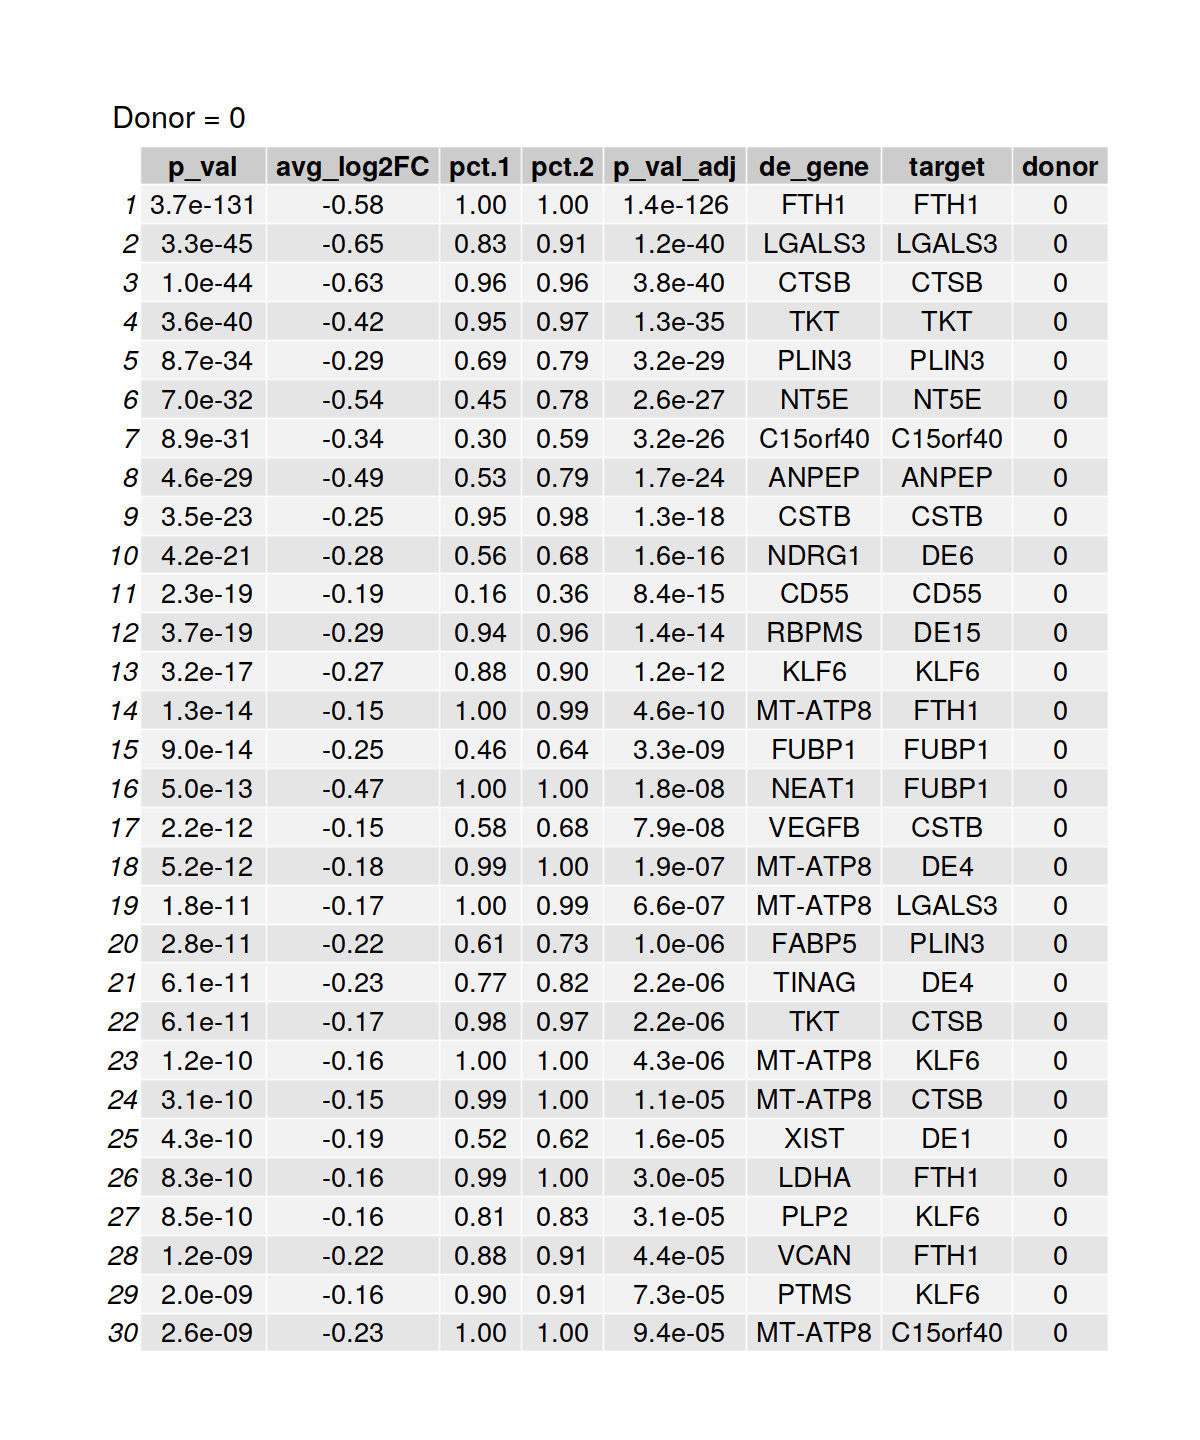

2 


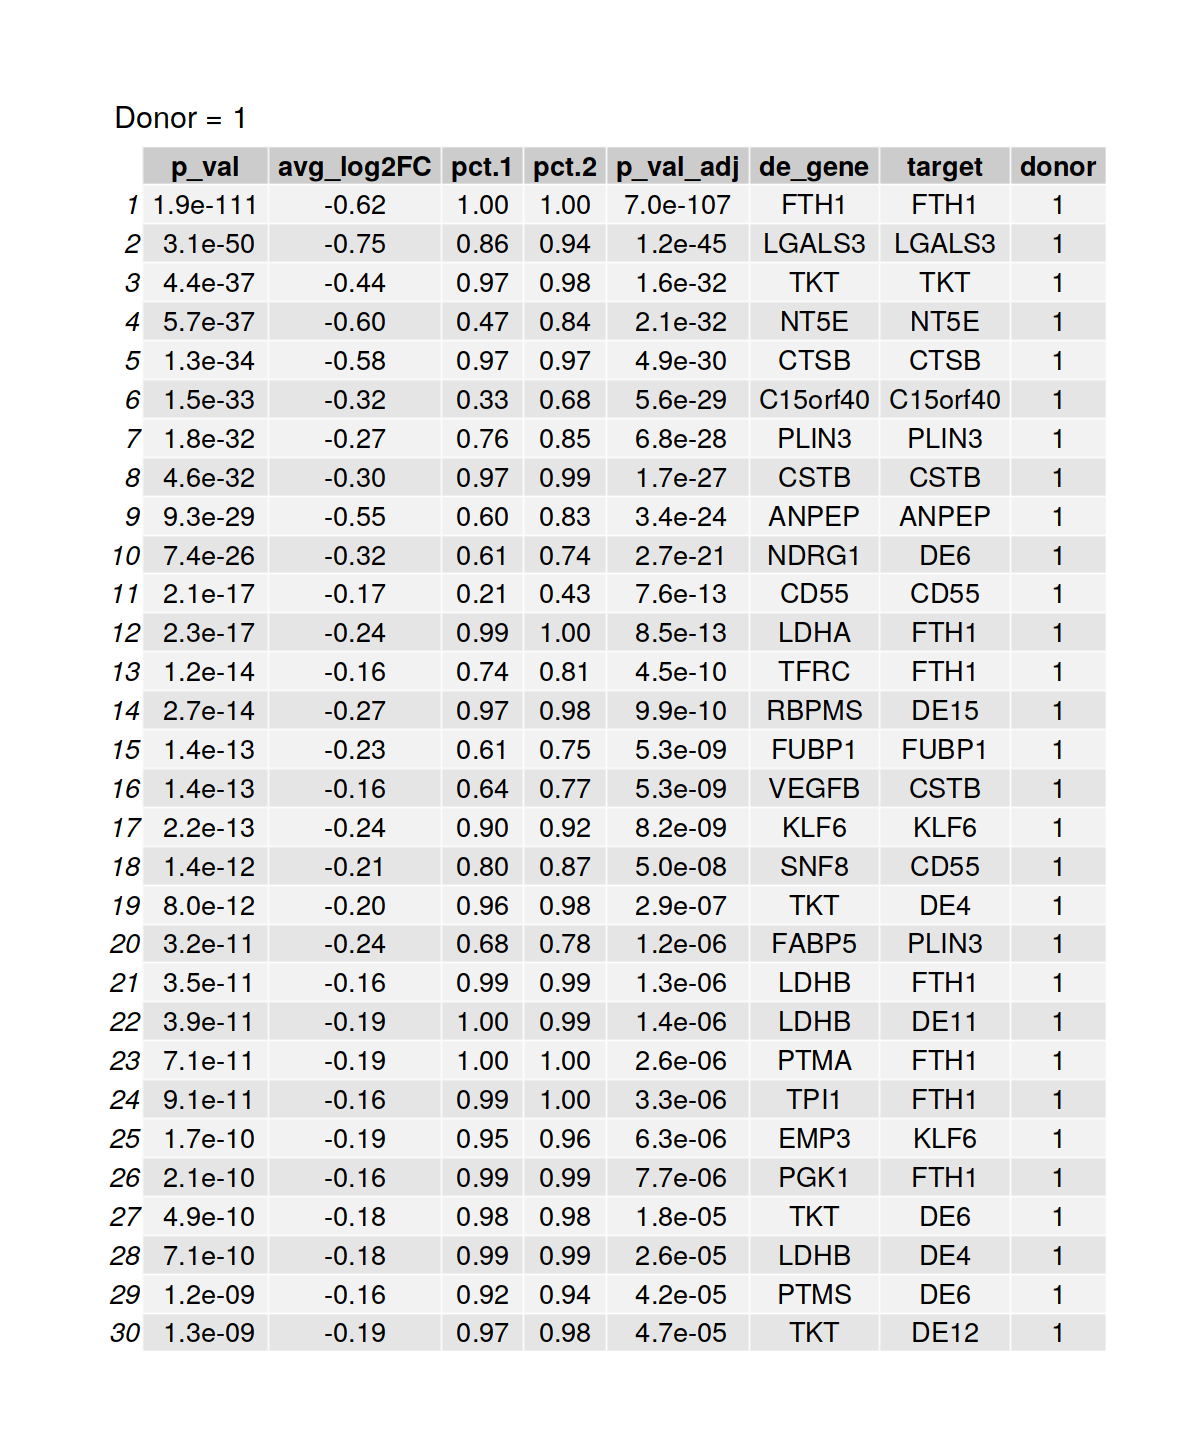

3 


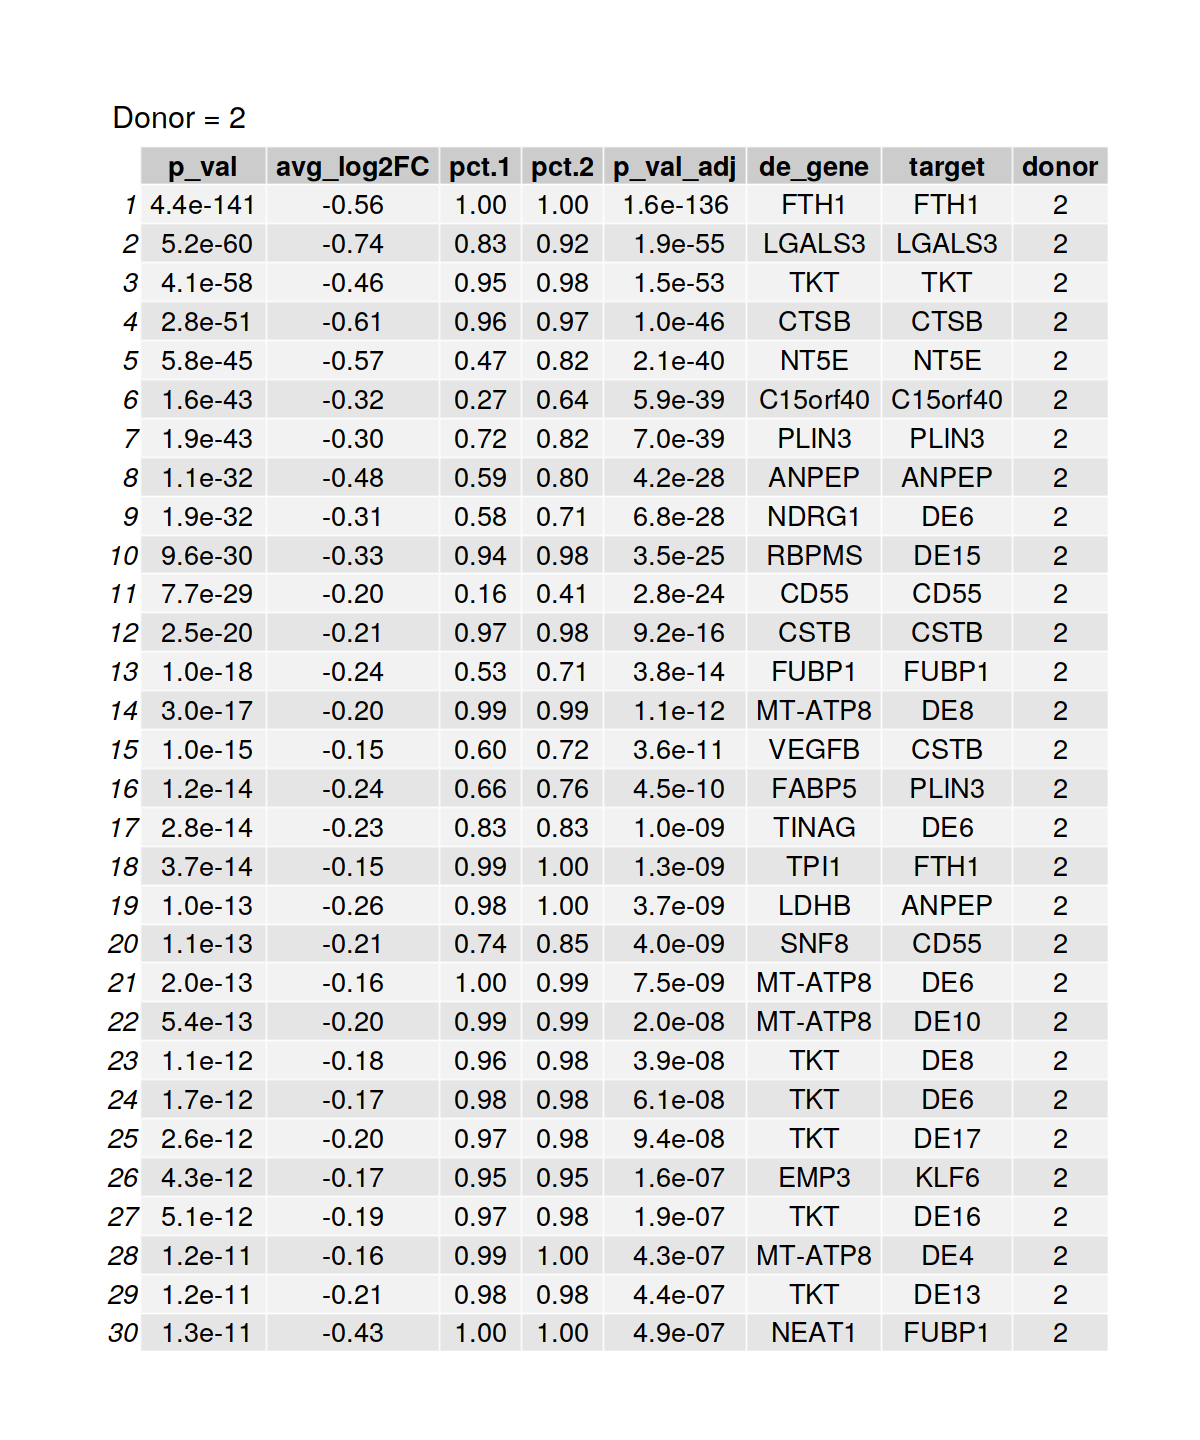

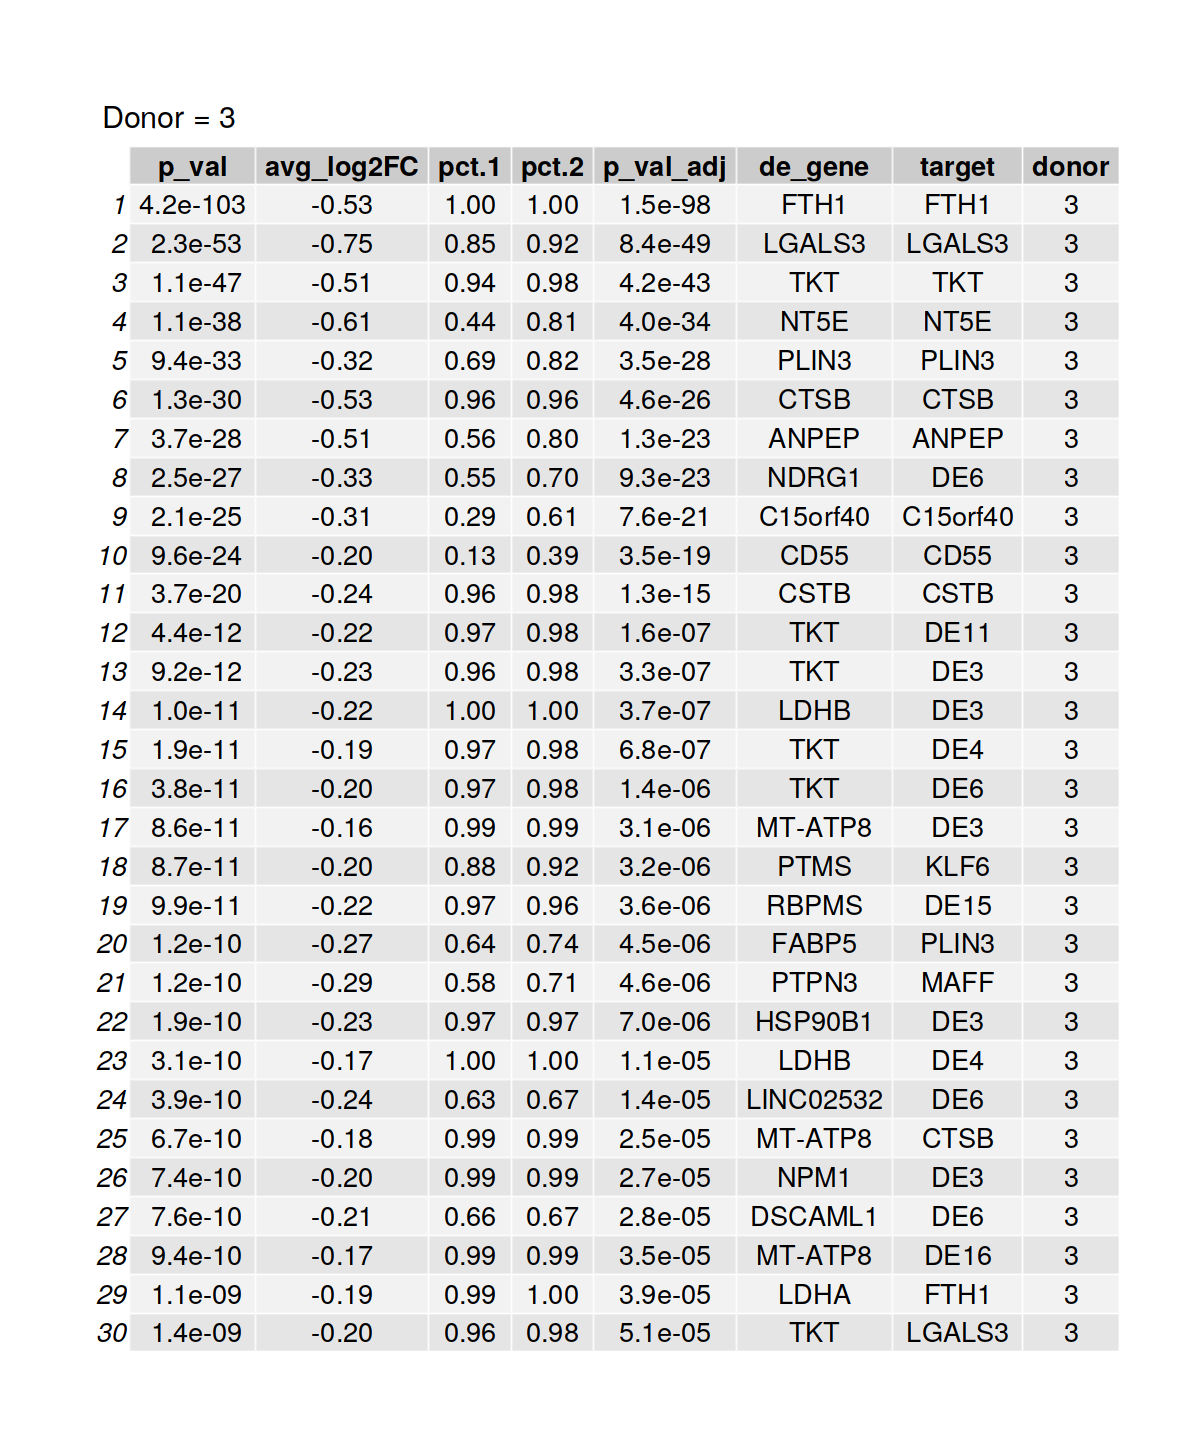

In [33]:
library(huxtable)
options(repr.plot.width = 10, repr.plot.height = 12)
for(donor_id in donors) {
    df_dummy = df_de %>% filter(avg_log2FC < 0 & p_val_adj < 0.05) %>% filter(donor == donor_id) %>% arrange(p_val_adj) %>% head(30)
    cat(green(donor_id, "\n"))
    title <- paste0("Donor = ", donor_id)
    tb <- ggtexttable(df_dummy, theme= ttheme(base_size = 16)) %>% tab_add_title(text = title, face = "plain", size = 18)
    print(tb)
}


## TSS controls

[1] "ANPEP"
Guide+ = 350 ; Guide- = 5297 
[1] "CD55"
Guide+ = 346 ; Guide- = 5301 
[1] "NT5E"
Guide+ = 223 ; Guide- = 5424 
[1] "FUBP1"
Guide+ = 259 ; Guide- = 5388 
[1] "C15orf40"
Guide+ = 248 ; Guide- = 5399 
[1] "MAFF"
Guide+ = 251 ; Guide- = 5396 
[1] "ANPEP"
Guide+ = 293 ; Guide- = 4347 
[1] "CD55"
Guide+ = 282 ; Guide- = 4358 
[1] "NT5E"
Guide+ = 195 ; Guide- = 4445 
[1] "FUBP1"
Guide+ = 237 ; Guide- = 4403 
[1] "C15orf40"
Guide+ = 215 ; Guide- = 4425 
[1] "MAFF"
Guide+ = 224 ; Guide- = 4416 


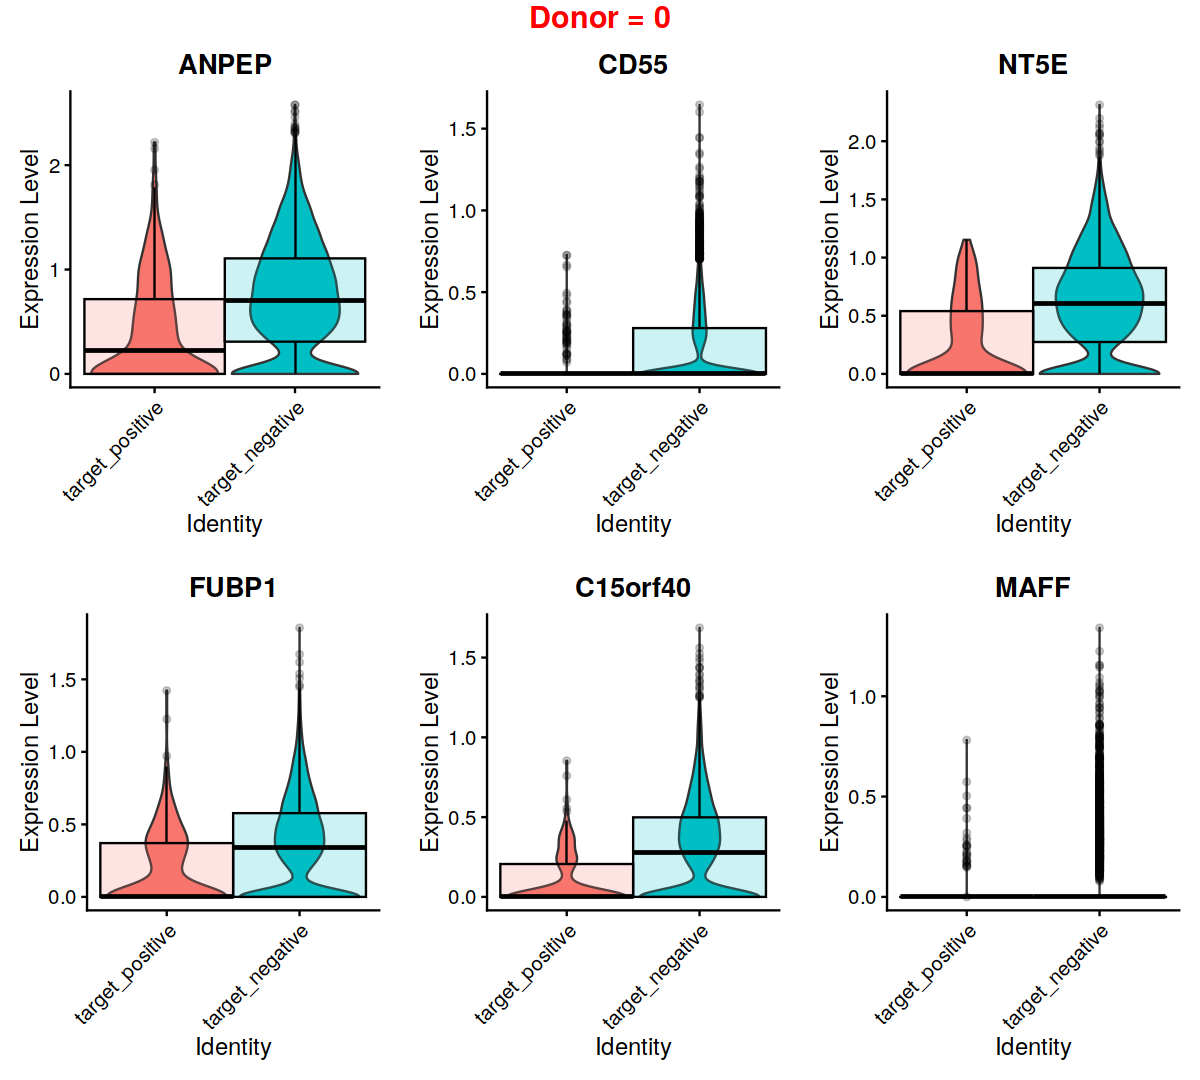

[1] "ANPEP"
Guide+ = 434 ; Guide- = 5803 
[1] "CD55"
Guide+ = 371 ; Guide- = 5866 
[1] "NT5E"
Guide+ = 257 ; Guide- = 5980 
[1] "FUBP1"
Guide+ = 331 ; Guide- = 5906 
[1] "C15orf40"
Guide+ = 302 ; Guide- = 5935 
[1] "MAFF"
Guide+ = 327 ; Guide- = 5910 


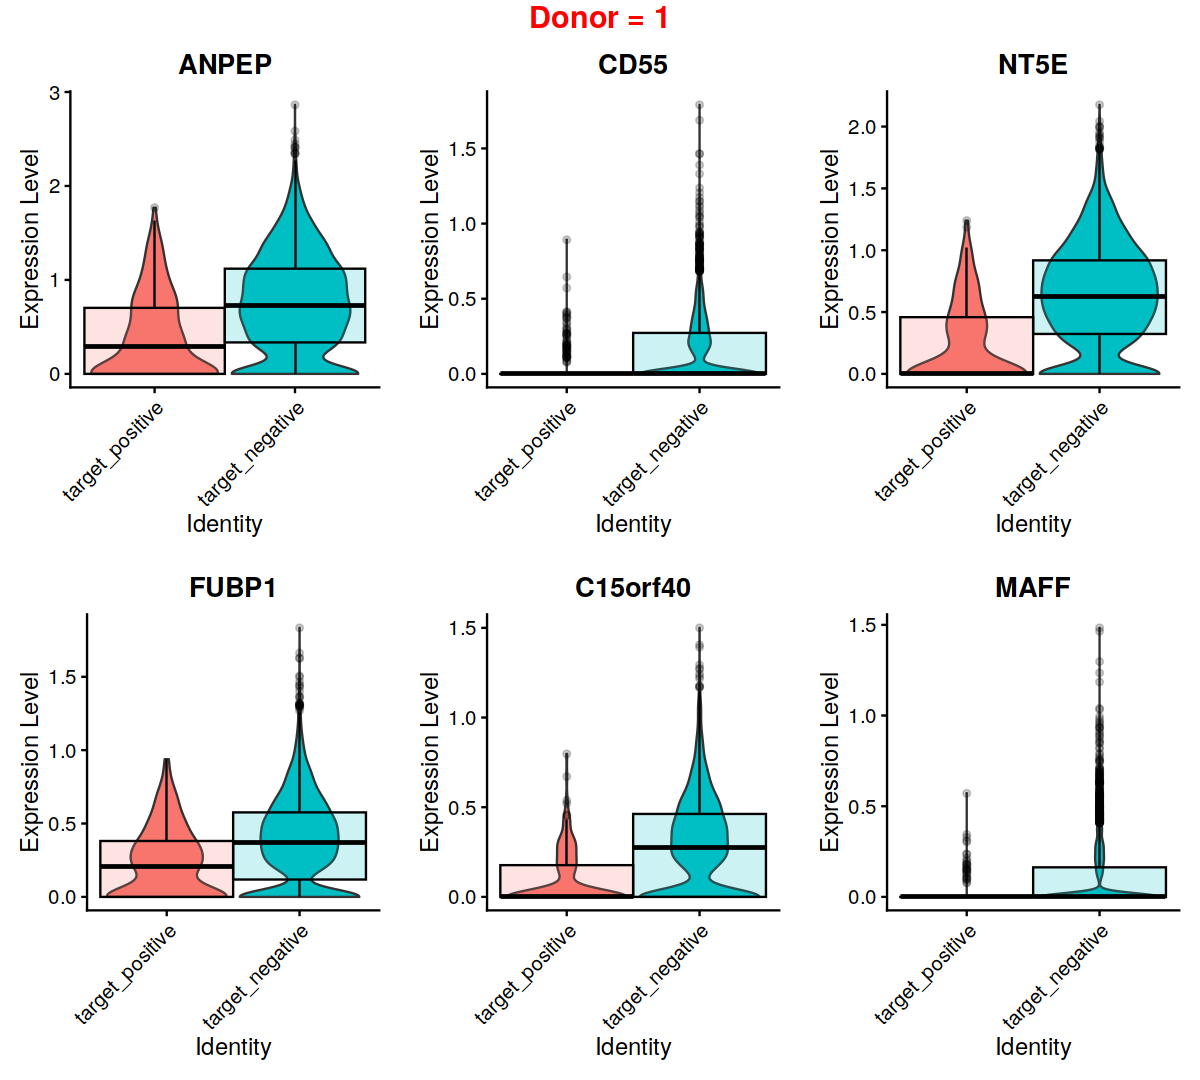

[1] "ANPEP"
Guide+ = 313 ; Guide- = 4526 
[1] "CD55"
Guide+ = 299 ; Guide- = 4540 
[1] "NT5E"
Guide+ = 214 ; Guide- = 4625 
[1] "FUBP1"
Guide+ = 233 ; Guide- = 4606 
[1] "C15orf40"
Guide+ = 209 ; Guide- = 4630 
[1] "MAFF"
Guide+ = 241 ; Guide- = 4598 


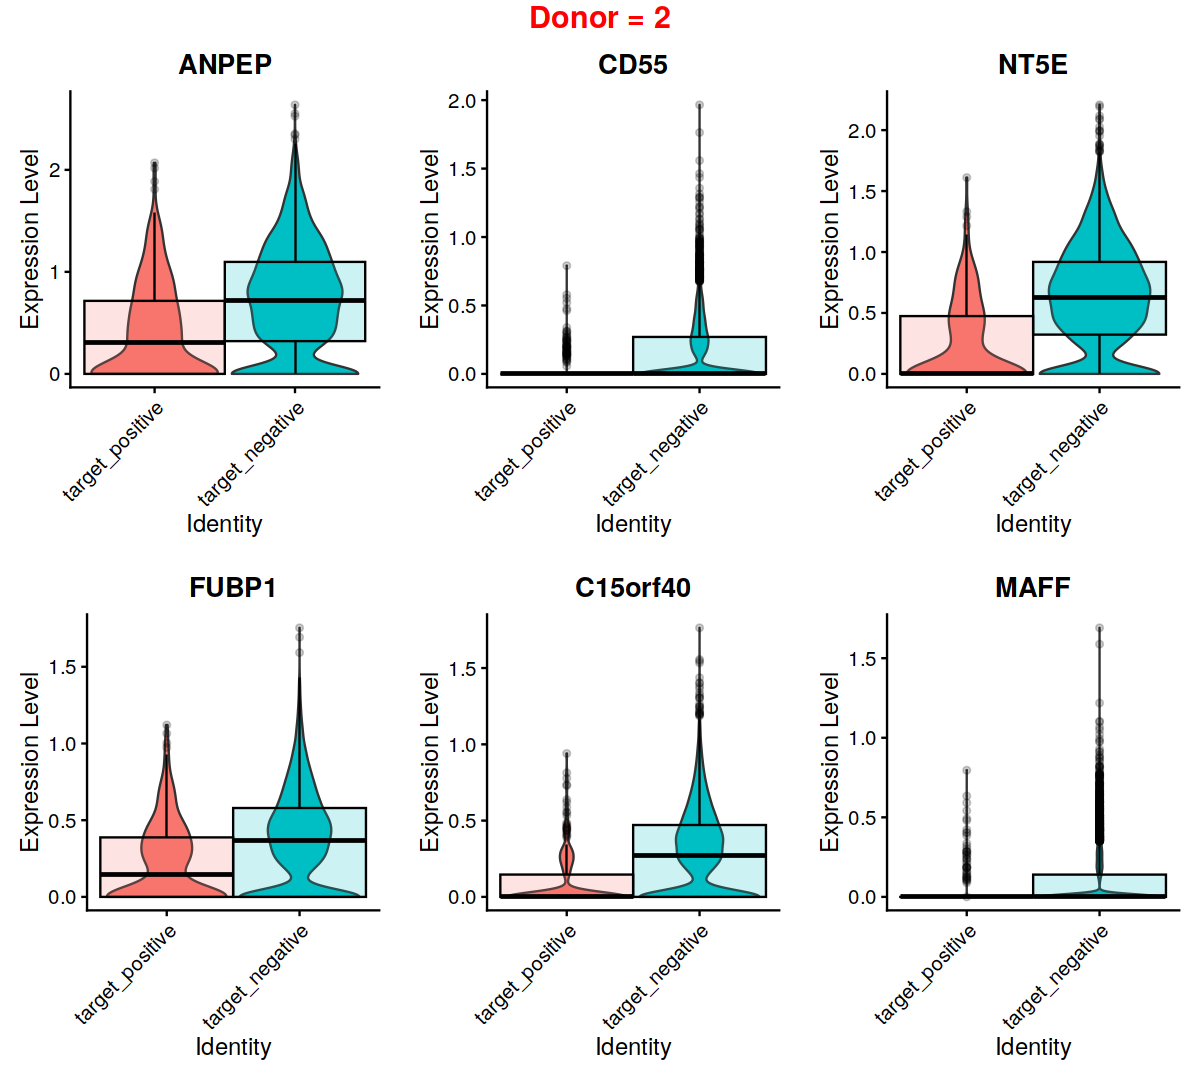

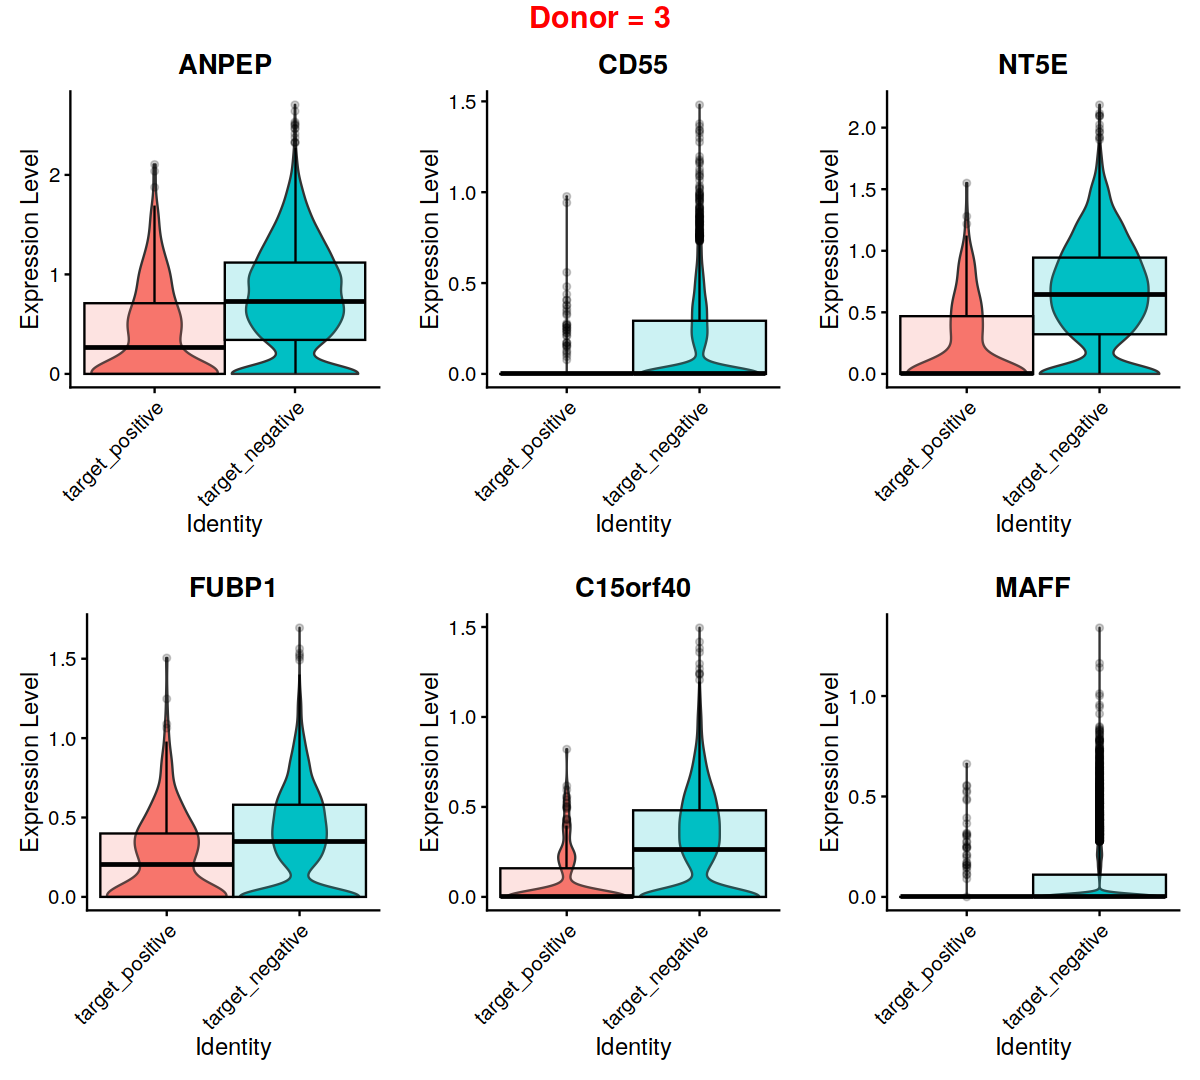

In [19]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)

    targets = unique(filter(df_guide, subclass=='tss')$alias)
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=10, repr.plot.height=9)
    p <- ggarrange(plotlist=plots, ncol=3, nrow = 2)
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))
    print(p)
}

## DE controls

[1] "FTH1"
Guide+ = 1004 ; Guide- = 4643 
[1] "PLIN3"
Guide+ = 629 ; Guide- = 5018 
[1] "TKT"
Guide+ = 589 ; Guide- = 5058 
[1] "LGALS3"
Guide+ = 628 ; Guide- = 5019 
[1] "CSTB"
Guide+ = 721 ; Guide- = 4926 
[1] "CTSB"
Guide+ = 665 ; Guide- = 4982 
[1] "KLF6"
Guide+ = 691 ; Guide- = 4956 
[1] "FTH1"
Guide+ = 865 ; Guide- = 3775 
[1] "PLIN3"
Guide+ = 544 ; Guide- = 4096 
[1] "TKT"
Guide+ = 488 ; Guide- = 4152 
[1] "LGALS3"
Guide+ = 522 ; Guide- = 4118 
[1] "CSTB"
Guide+ = 573 ; Guide- = 4067 
[1] "CTSB"
Guide+ = 558 ; Guide- = 4082 
[1] "KLF6"
Guide+ = 557 ; Guide- = 4083 


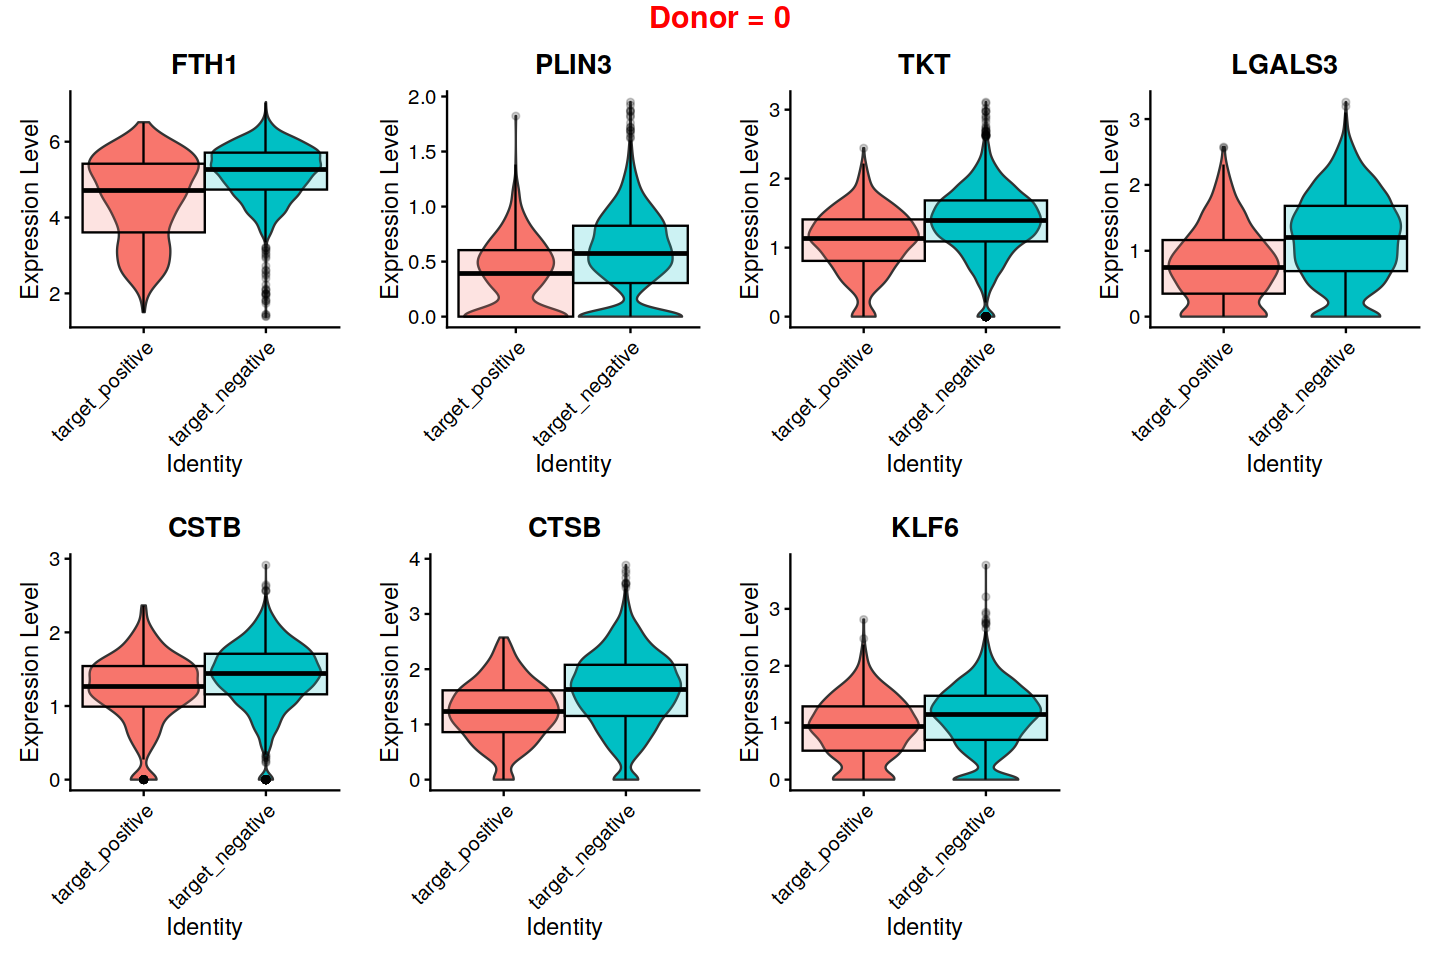

[1] "FTH1"
Guide+ = 1211 ; Guide- = 5026 
[1] "PLIN3"
Guide+ = 683 ; Guide- = 5554 
[1] "TKT"
Guide+ = 705 ; Guide- = 5532 
[1] "LGALS3"
Guide+ = 728 ; Guide- = 5509 
[1] "CSTB"
Guide+ = 772 ; Guide- = 5465 
[1] "CTSB"
Guide+ = 772 ; Guide- = 5465 
[1] "KLF6"
Guide+ = 739 ; Guide- = 5498 


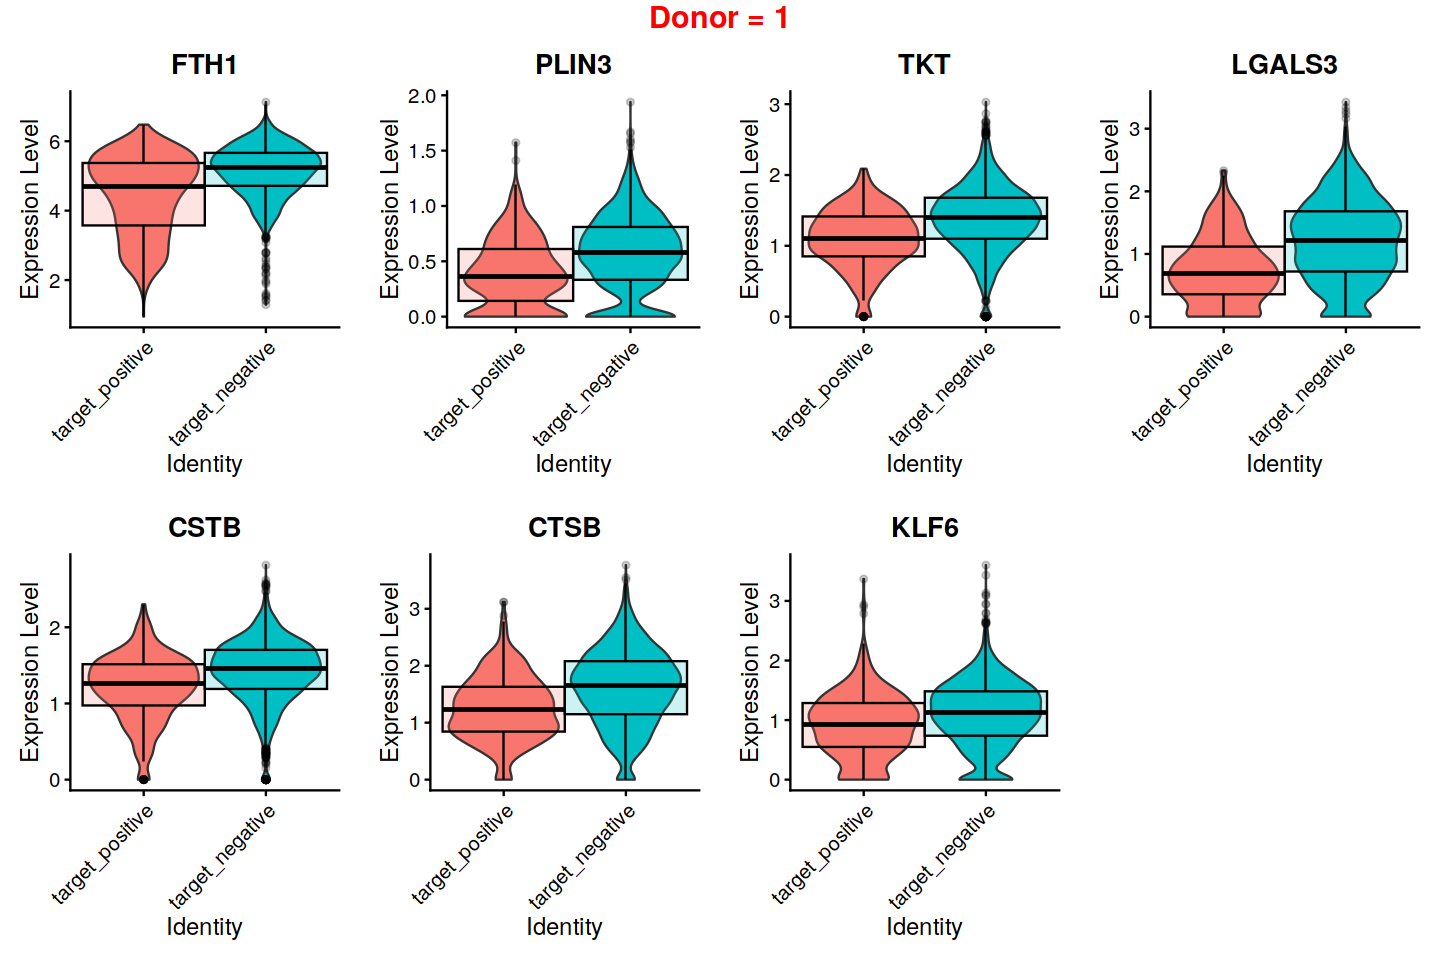

[1] "FTH1"
Guide+ = 917 ; Guide- = 3922 
[1] "PLIN3"
Guide+ = 501 ; Guide- = 4338 
[1] "TKT"
Guide+ = 473 ; Guide- = 4366 
[1] "LGALS3"
Guide+ = 573 ; Guide- = 4266 
[1] "CSTB"
Guide+ = 576 ; Guide- = 4263 
[1] "CTSB"
Guide+ = 587 ; Guide- = 4252 
[1] "KLF6"
Guide+ = 563 ; Guide- = 4276 


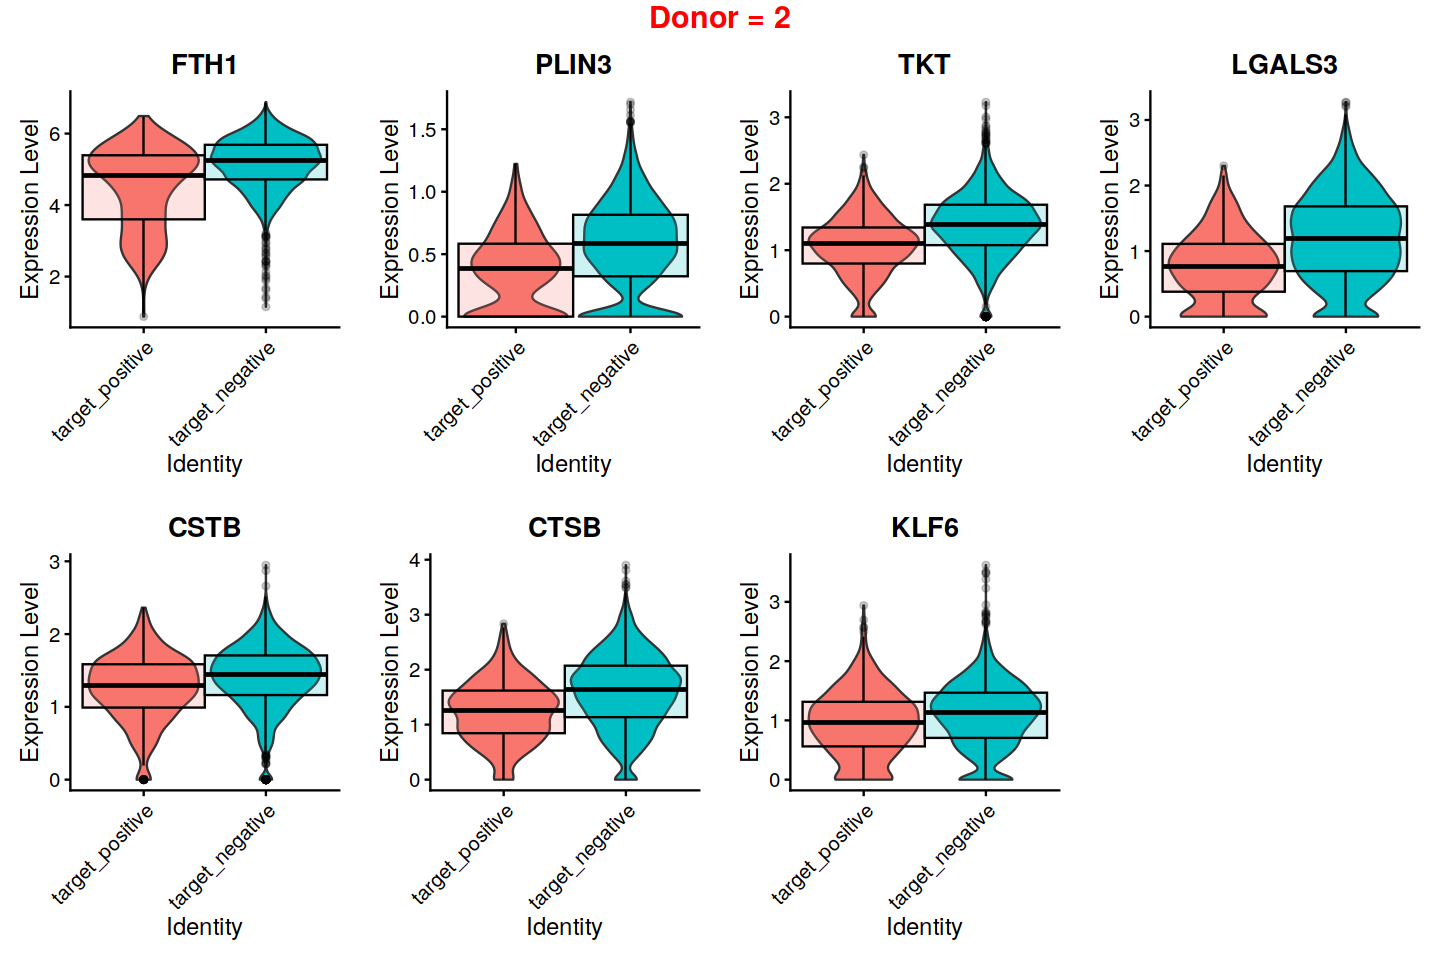

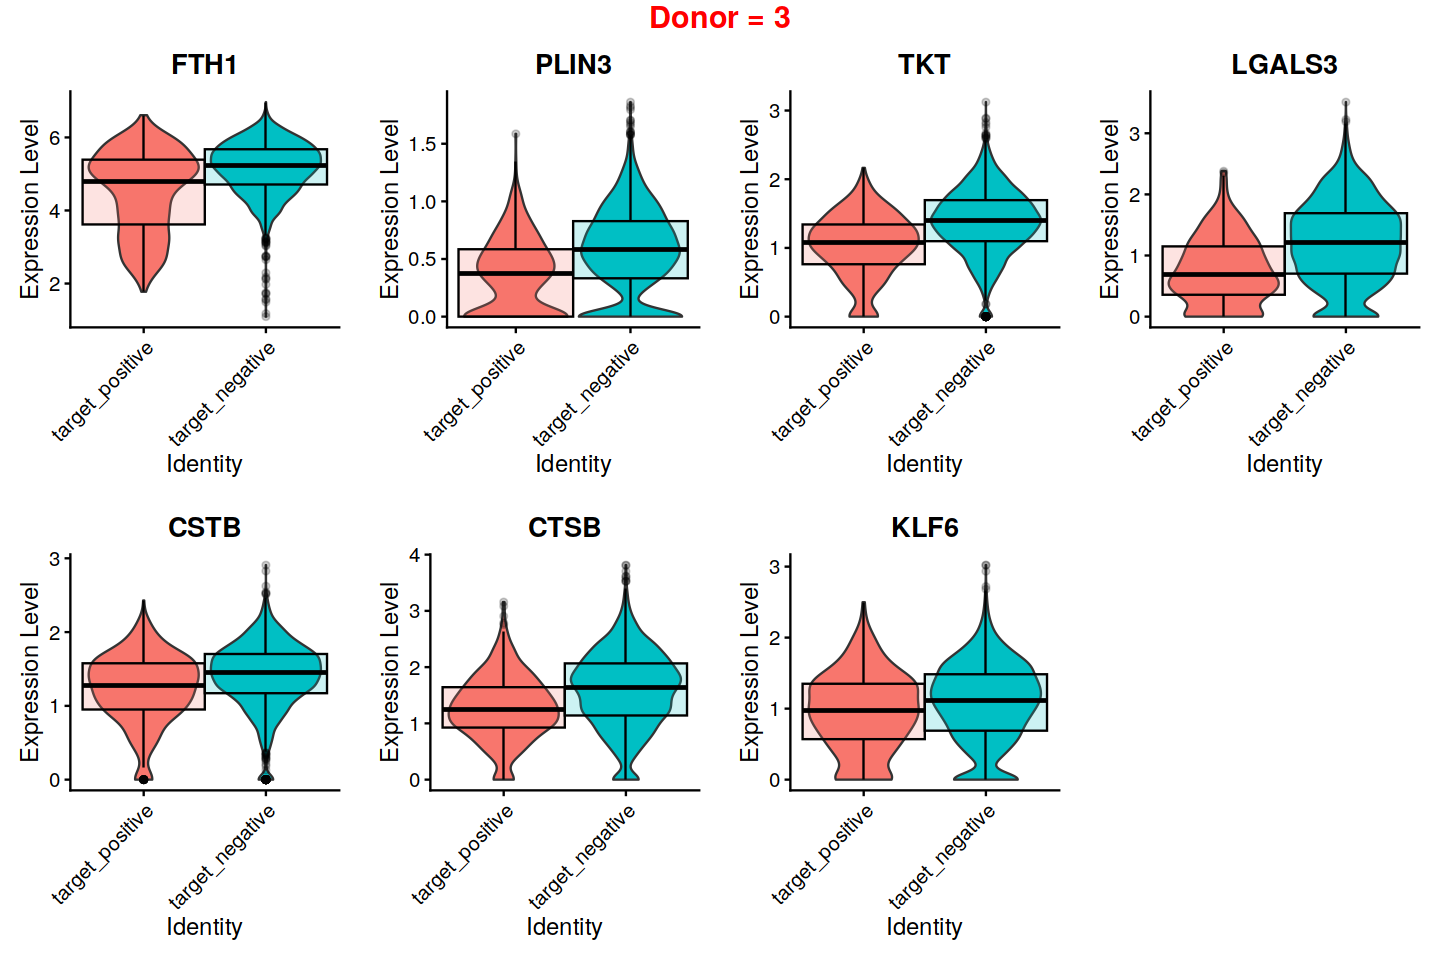

In [20]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)
    
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=12, repr.plot.height=8)
    p <- ggarrange(plotlist=plots, ncol=4, nrow = 2) 
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))  
    print(p)
}

## CKD DE 

Adding an extra gene or two the regulated_genes list to use as controls

[1] "DE6"
Guide+ = 886 ; Guide- = 4762 


Picking joint bandwidth of 0.08

Picking joint bandwidth of 0.0984

Picking joint bandwidth of 0.123



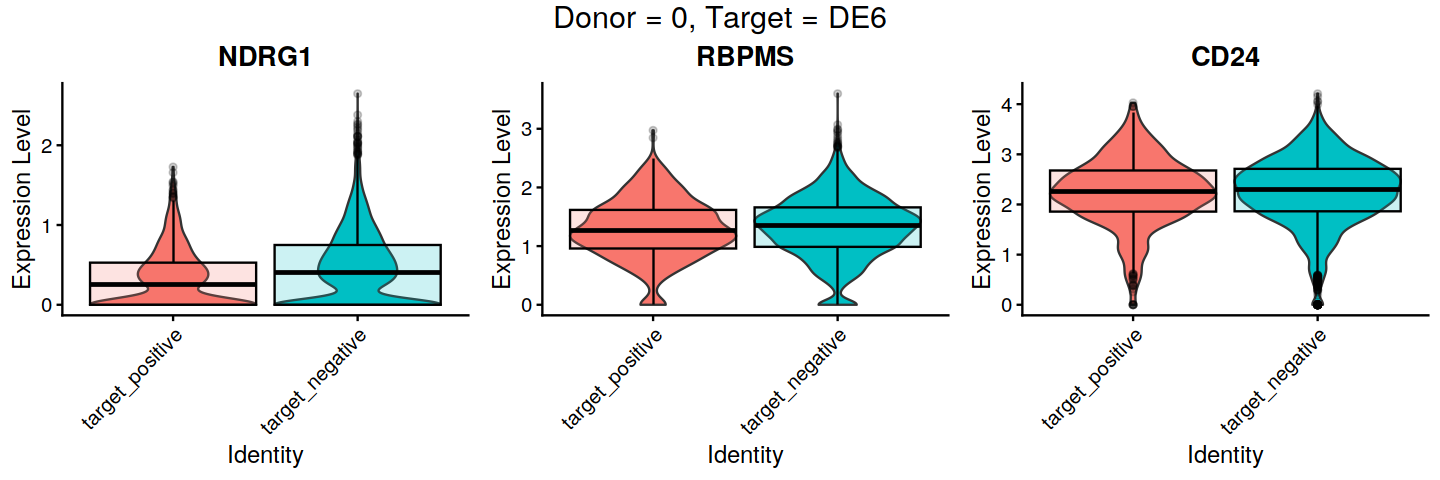

[1] "DE15"
Guide+ = 712 ; Guide- = 4935 


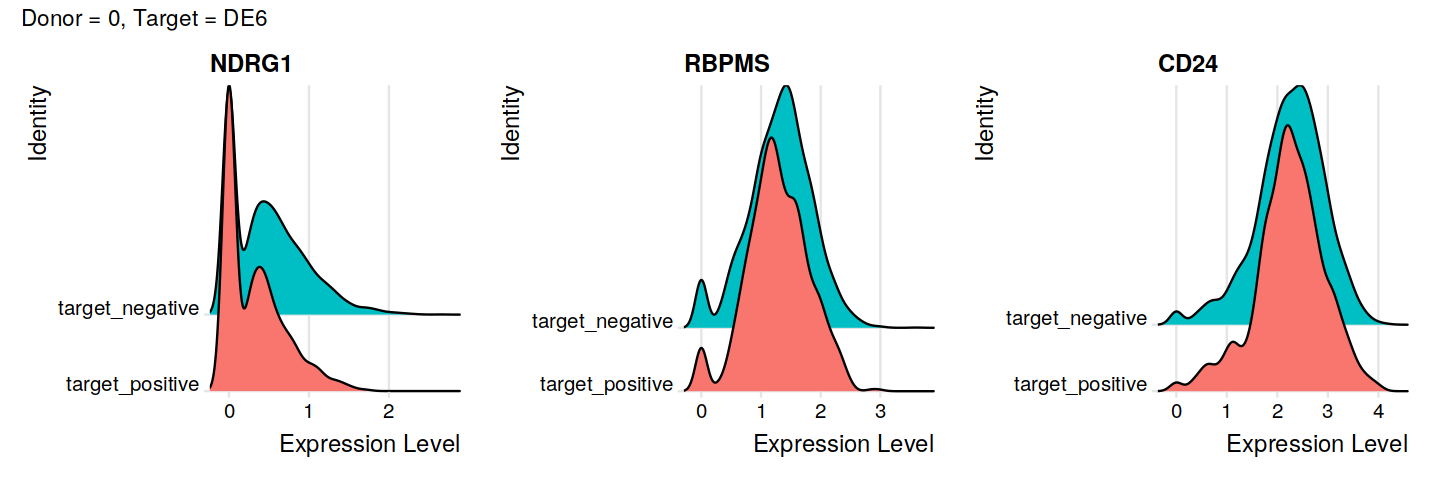

Picking joint bandwidth of 0.0889

Picking joint bandwidth of 0.101

Picking joint bandwidth of 0.128



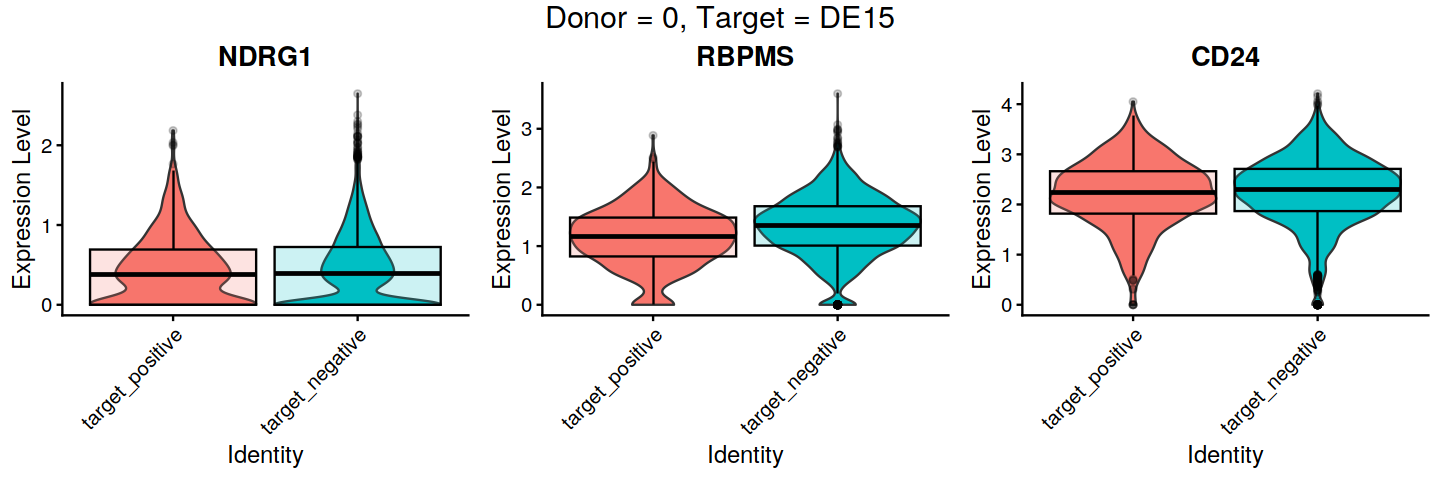

[1] "DE6"
Guide+ = 712 ; Guide- = 3929 


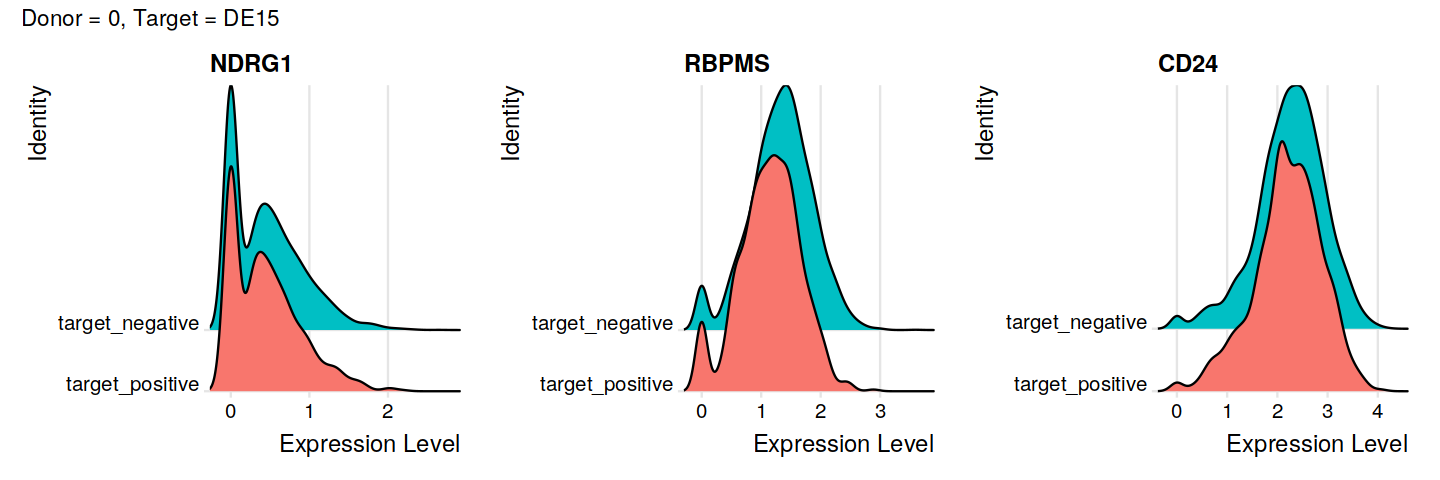

Picking joint bandwidth of 0.0778

Picking joint bandwidth of 0.0978

Picking joint bandwidth of 0.129



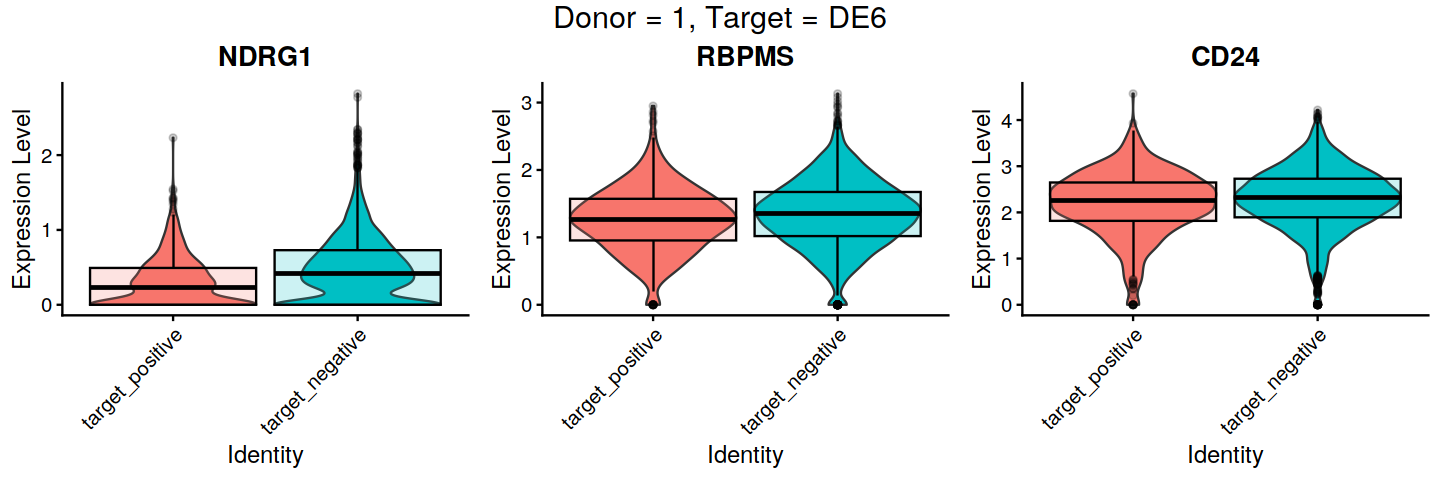

[1] "DE15"
Guide+ = 580 ; Guide- = 4060 


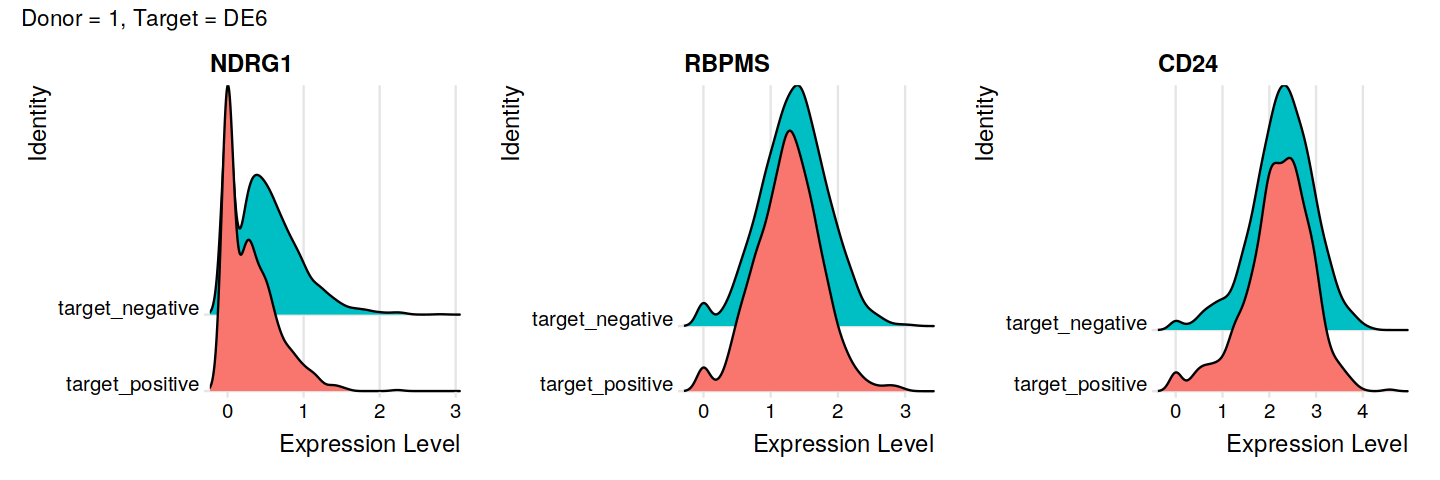

Picking joint bandwidth of 0.0871

Picking joint bandwidth of 0.0941

Picking joint bandwidth of 0.13



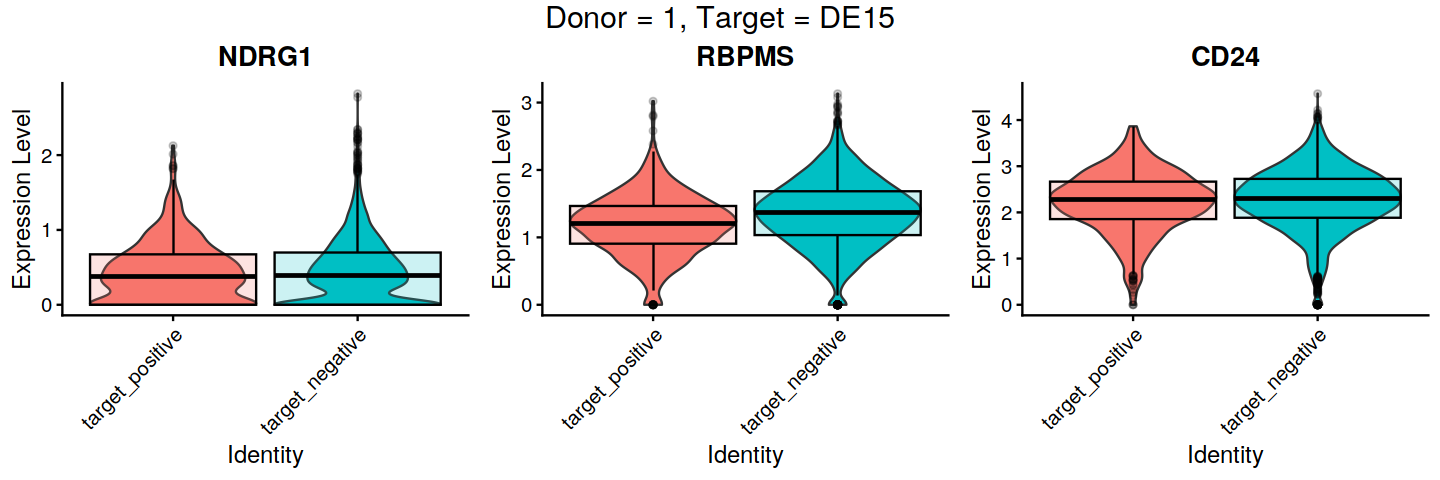

[1] "DE6"
Guide+ = 936 ; Guide- = 5302 


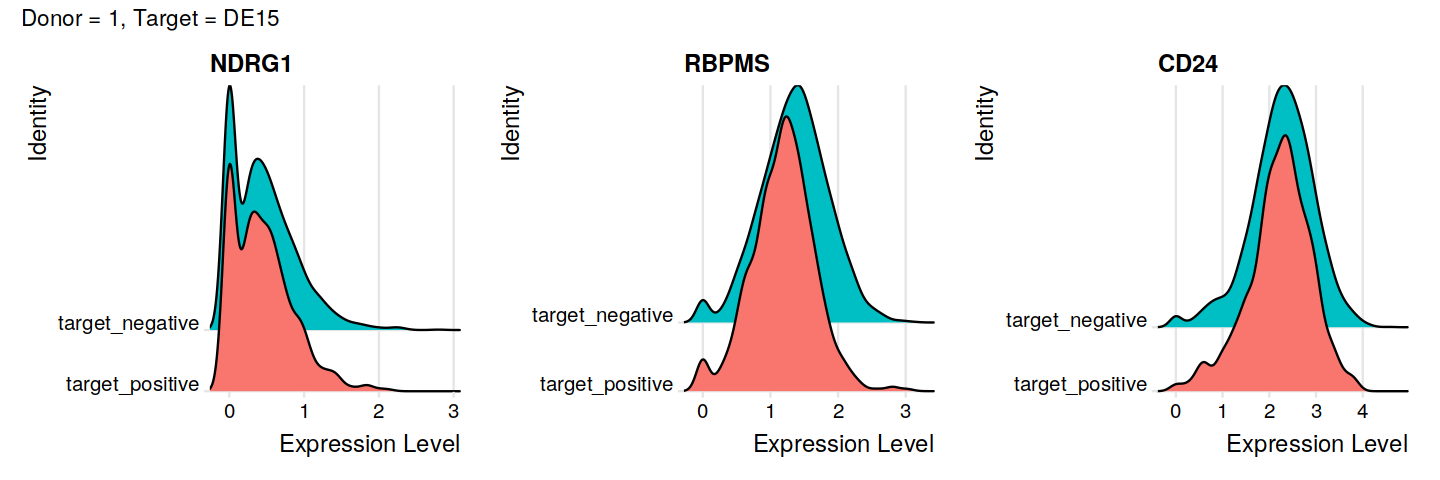

Picking joint bandwidth of 0.0739

Picking joint bandwidth of 0.0928

Picking joint bandwidth of 0.122



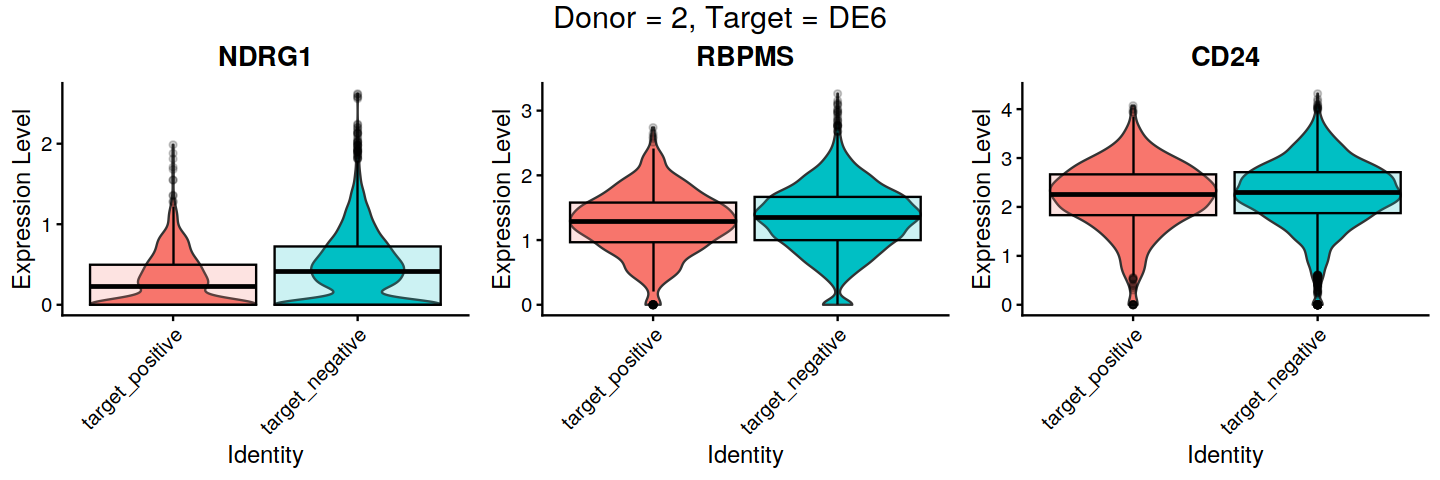

[1] "DE15"
Guide+ = 750 ; Guide- = 5487 


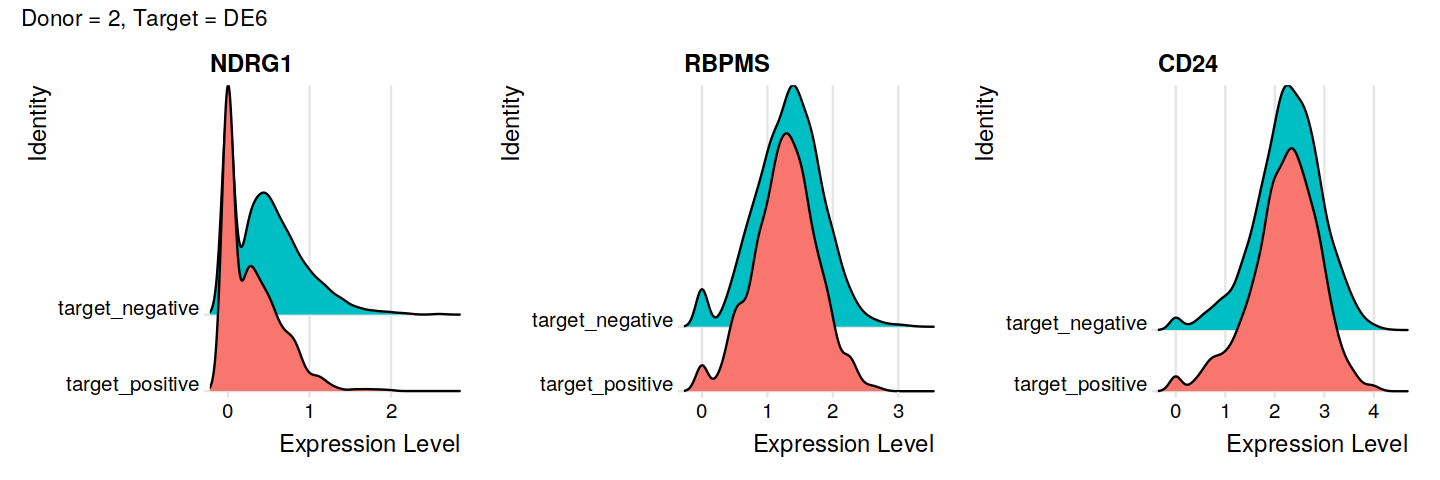

Picking joint bandwidth of 0.0835

Picking joint bandwidth of 0.0989

Picking joint bandwidth of 0.127



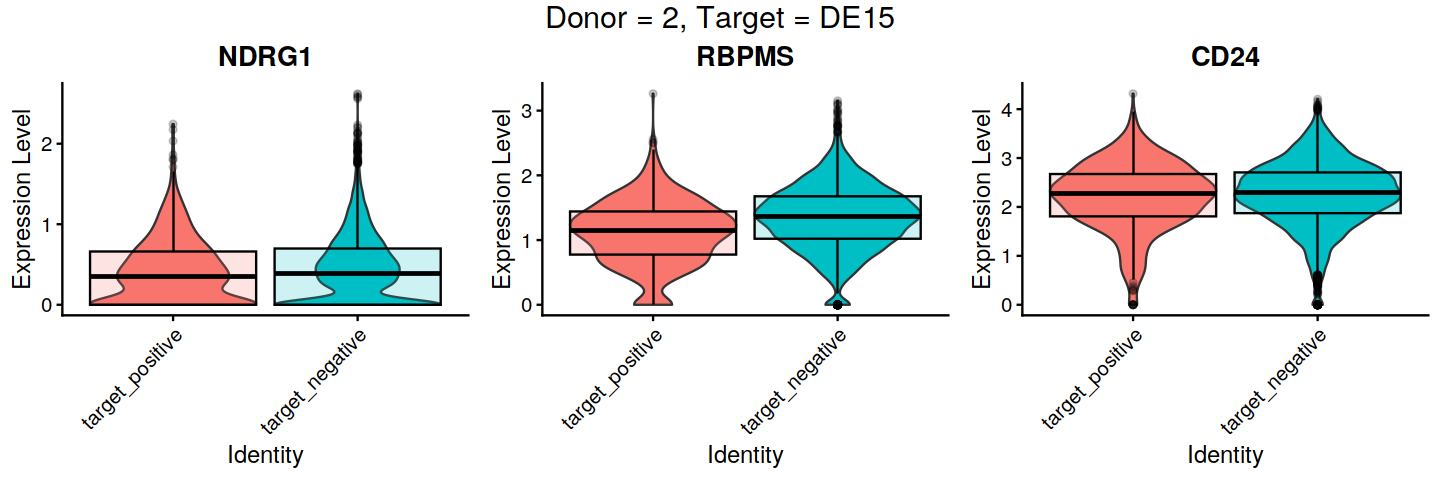

[1] "DE6"
Guide+ = 713 ; Guide- = 4127 


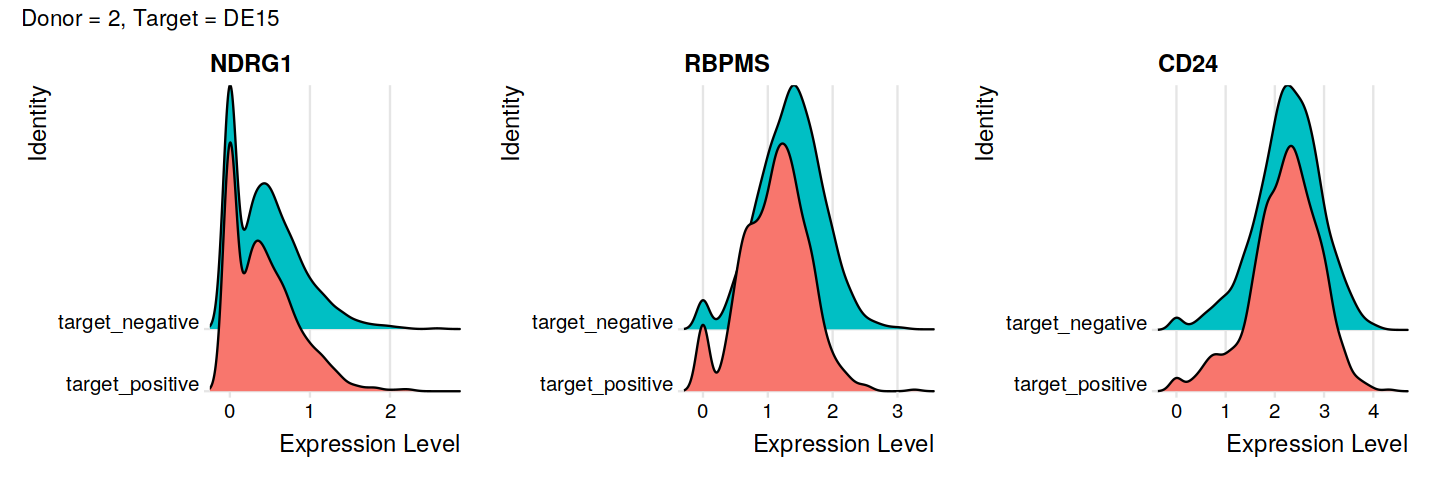

Picking joint bandwidth of 0.0766

Picking joint bandwidth of 0.103

Picking joint bandwidth of 0.128



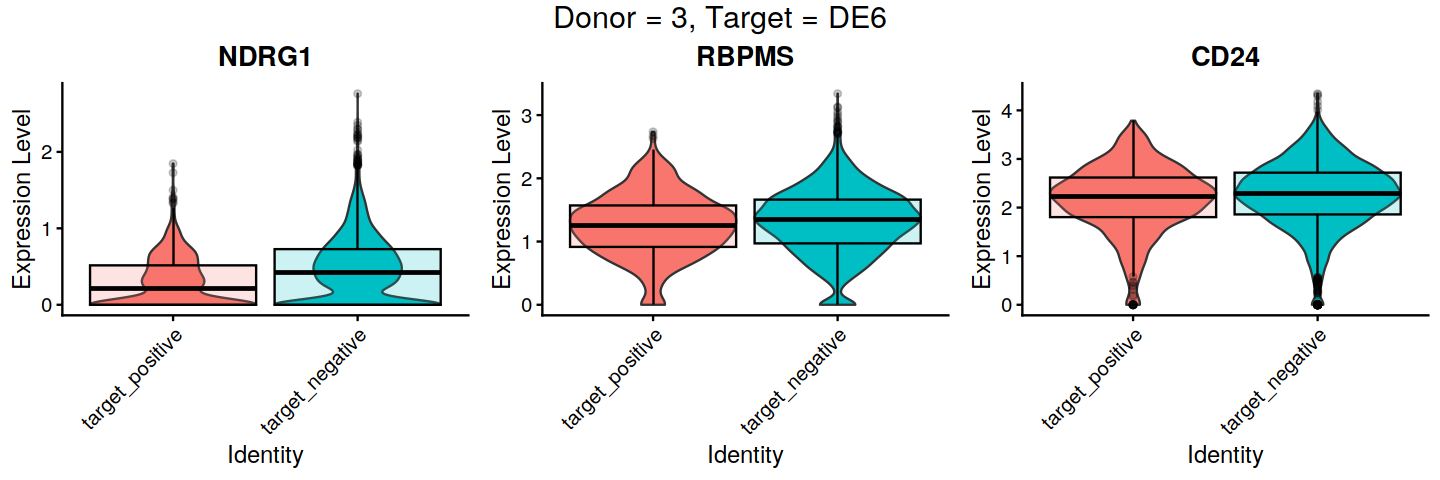

[1] "DE15"
Guide+ = 620 ; Guide- = 4219 


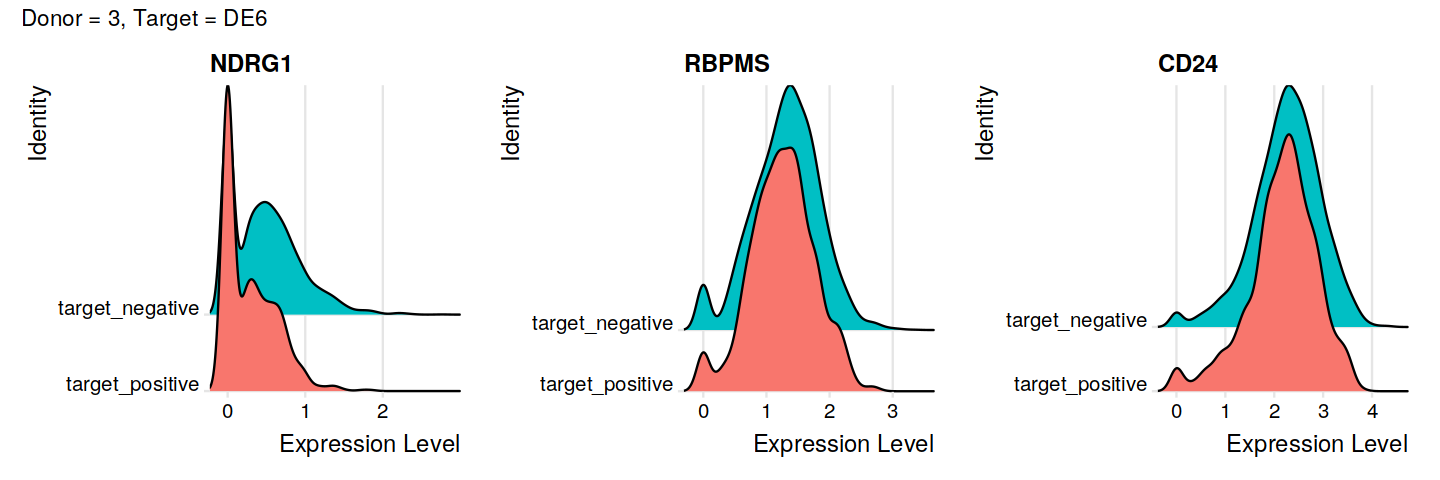

Picking joint bandwidth of 0.0886

Picking joint bandwidth of 0.102

Picking joint bandwidth of 0.136



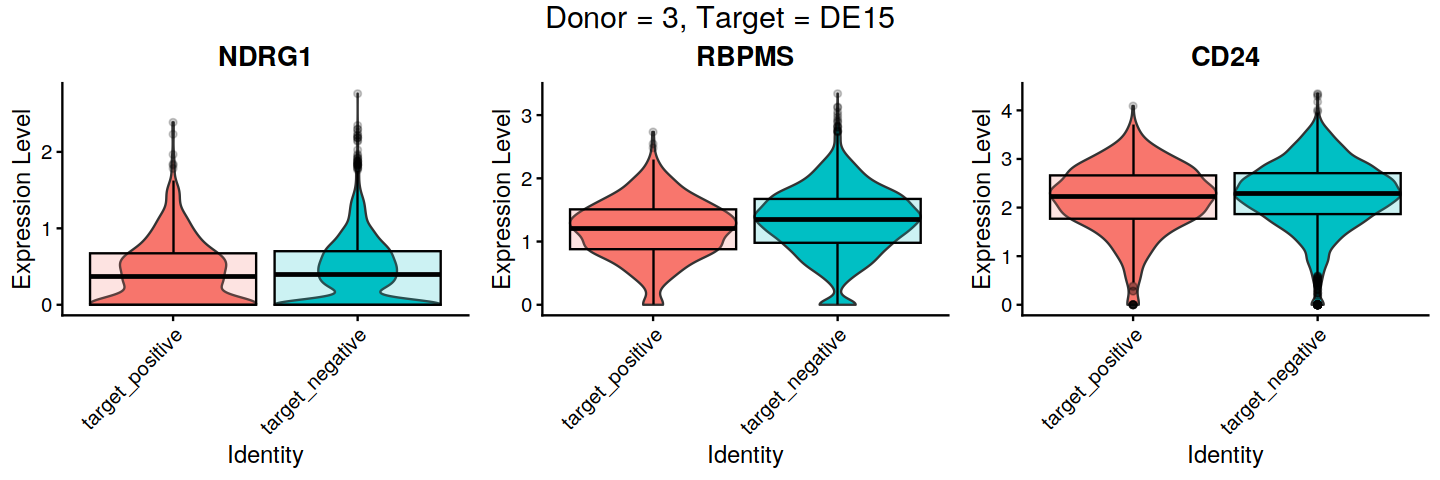

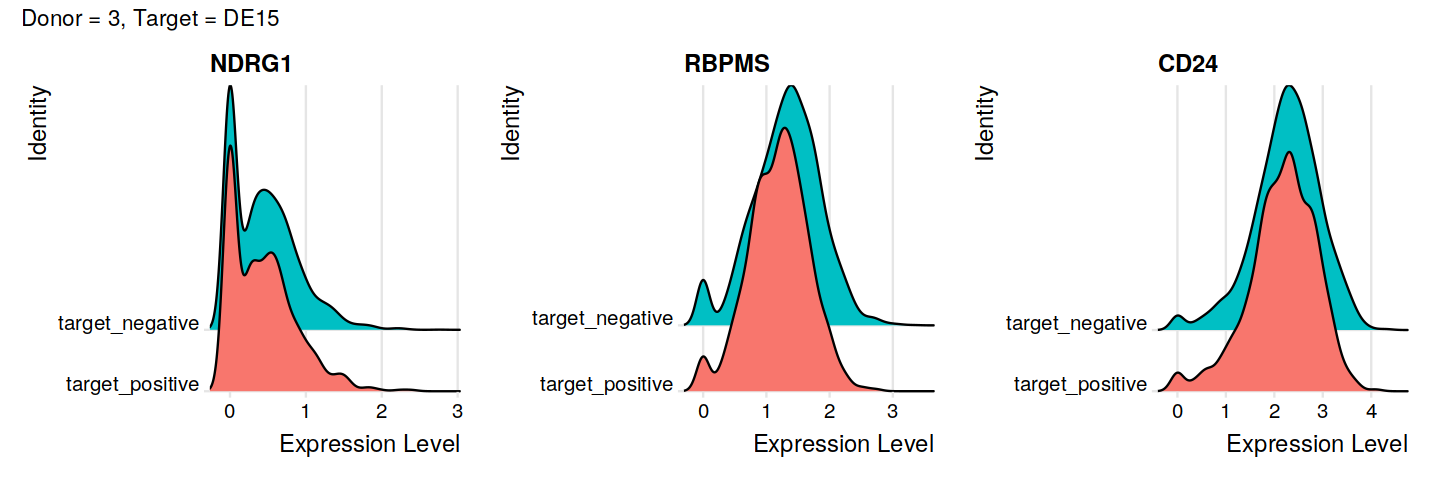

In [21]:
targets = c("DE6", "DE15")
regulated_genes = c("NDRG1", "RBPMS", "CD24")

donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)    

    for(i in seq_along(targets)) {        
        target = targets[i]
        title <- paste0("Donor = ", donor_id, ", Target = ", target)
        print(target)
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_donor <- mark_target_pos_neg(
            seurat_donor, 
            perturbed_cells_by_guide, 
            guides, 
            print_counts = T
        ) 

        options(repr.plot.width=6, repr.plot.height=4)
        plots <- VlnPlot(
                object = seurat_donor,
                features = regulated_genes, 
                idents = NULL, 
                pt.size = 0, 
                sort = F, 
                ncol = 3,  
                combine = F  
            ) 

        for(i in 1:length(plots)) {
            plots[[i]] <- plots[[i]] + 
            NoLegend() +
            geom_boxplot(width=2, color="black", alpha=0.2)
        }
        plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
        plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  

        options(repr.plot.width=12, repr.plot.height=4)
        plt2 <- RidgePlot(
            object = seurat_donor,
            features = regulated_genes, 
            idents = NULL,  
            sort = F, 
            ncol = 3,    
        ) + plot_annotation(title = title)

        print(plt1) 
        print(plt2)
    }

}

In [27]:
print(df_de %>% filter(donor == donor_id) %>% arrange(p_val_adj) )

       p_val avg_log2FC pct.1 pct.2 p_val_adj    de_gene   target donor
1   5.1e-103      -0.53  1.00  1.00   1.9e-98       FTH1     FTH1     3
2    2.5e-53      -0.75  0.85  0.92   9.2e-49     LGALS3   LGALS3     3
3    1.5e-47      -0.51  0.94  0.98   5.5e-43        TKT      TKT     3
4    1.1e-38      -0.61  0.44  0.81   4.0e-34       NT5E     NT5E     3
5    9.1e-33      -0.32  0.69  0.82   3.3e-28      PLIN3    PLIN3     3
6    1.5e-30      -0.53  0.96  0.96   5.7e-26       CTSB     CTSB     3
7    3.9e-28      -0.51  0.56  0.80   1.4e-23      ANPEP    ANPEP     3
8    2.6e-27      -0.33  0.55  0.70   9.5e-23      NDRG1      DE6     3
9    1.9e-25      -0.31  0.29  0.61   7.1e-21   C15orf40 C15orf40     3
10   9.7e-15       0.26  0.99  0.98   3.6e-10       PSAP     FTH1     3
11   2.2e-14       0.32  0.94  0.89   7.9e-10       MDM2      DE4     3
12   6.2e-14       0.28  0.98  0.98   2.3e-09       PSAP     DE15     3
13   3.0e-13       0.25  0.99  0.98   1.1e-08       PSAP      DE